In [1]:
import numpy as np 
import pandas as pd 
from fbprophet import Prophet
import matplotlib.pyplot as plt
%matplotlib inline
import datetime 
import math
from keras.models import Sequential, Model
from keras.layers import Input, Activation, GRU, Dense, LSTM, RepeatVector
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import scale, StandardScaler, RobustScaler, normalize
import holidays

Using TensorFlow backend.


In [2]:
# !pip install fbprophet
# !pip install sklearn

In [145]:
content_type = 100
df = pd.read_csv('train/train_1.csv',nrows=content_type) # 100 Content Type
df = df.fillna(0)
arr = df.values[:,1:]
start_date = df.columns[1].split('-')
start_date_weekday = datetime.datetime(int(start_date[0]),int(start_date[1]),int(start_date[2]))
weekday = start_date_weekday.weekday()
weekday_data = np.arange(weekday,len(df.columns)+weekday,1)
f = lambda x: x%7
weekday_data = f(weekday_data)


In [39]:
holiday = holidays.CA() + holidays.US() + holidays.IND()
holiday_data = []
for day in df.columns[1:]:
    holiday_data.append(int(day in holiday))
    
print(holiday_data.count(1))

33


In [5]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


### GRU + features

- 1 day + EMA 

In [160]:
num_hidden_units = 64
num_outputs = 1
windows = [5]
exp_avg = None
sim_avg = None
alpha = 0.1

1122.123942694814


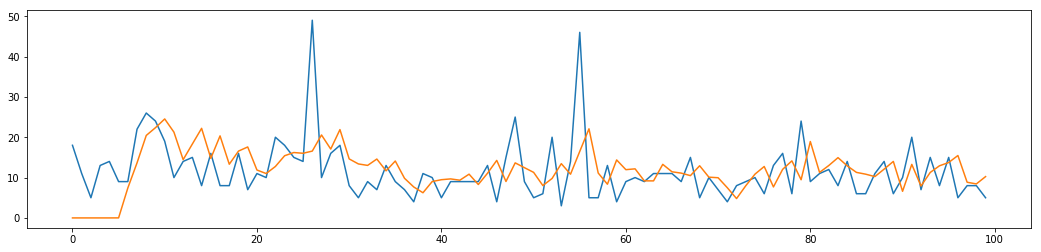

In [161]:
for r, window in enumerate(windows):
    preds = np.zeros((arr.shape[0], arr.shape[1]))
    model = Sequential()
    model.add(GRU(num_hidden_units))
    model.add(Dense(num_outputs))
    model.add(Activation('relu'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    for w in range(window):
        preds[:, w] = 0
    for i in range(window, arr.shape[1]): # i -> timestep
        if exp_avg is None or sim_avg is None:
            exp_avg = arr[:, i-1]
            sim_avg = arr[:, i-1]
        else:
            exp_avg = alpha*arr[:, i-1] + (1-alpha)*exp_avg
            sim_avg = (sim_avg*i-1 + arr[:, i-1])/i
        x = scale(np.concatenate((np.copy(arr[:, i-1 : i]), exp_avg.reshape(-1,1)), axis=1).astype(float)).reshape(-1, 1, 2)
        y = np.copy(arr[:, i]).reshape(-1, 1)
        for k in range(1):
            x[:, k, :] = scale(x[:, k, :])
        p = model.predict(x).flatten()
        preds[:, i] = p
        model.fit(x, y, epochs=100, verbose=0)
    print(mse(preds[:, 1:],arr[:, 1:]))
    plt.plot(arr[0][:100])
    plt.plot(preds[0][:100])

- 1 day + EMA + weekday

146556.14747319836


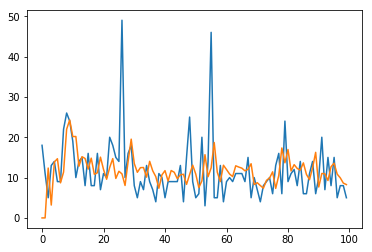

In [11]:
exp_avg = None
windows = [1]

for r, window in enumerate(windows):
    preds = np.zeros((arr.shape[0], arr.shape[1]))
    model = Sequential()
    model.add(GRU(num_hidden_units))
    model.add(Dense(num_outputs))
    model.add(Activation('relu'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    for w in range(window):
        preds[:, w] = 0
    for i in range(window, arr.shape[1]): # i -> timestep
        if exp_avg is None:
            exp_avg = arr[:, i-1]
        else:
            exp_avg = alpha*arr[:, i-1] + (1-alpha)*exp_avg
        x = scale(np.concatenate((np.copy(arr[:, i-1 : i]), exp_avg.reshape(-1,1),weekday_data[i]*np.ones(arr.shape[0],dtype=int).reshape(-1,1)), axis=1).astype(float)).reshape(-1, 1, 3)
        y = np.copy(arr[:, i]).reshape(-1, 1)
        for k in range(1):
            x[:, k, :] = scale(x[:, k, :])
        p = model.predict(x).flatten()
        preds[:, i] = p
        model.fit(x, y, epochs=100, verbose=0)
#         week += 1
    print(mse(preds[:, 1:],arr[:, 1:]))
    plt.plot(arr[0][:100])
    plt.plot(preds[0][:100])

1 day+ EMA + weekday + holiday

145330.74507006


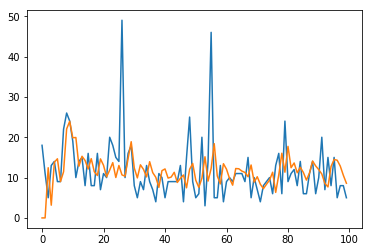

In [37]:
exp_avg = None
windows = [1]

for r, window in enumerate(windows):
    preds = np.zeros((arr.shape[0], arr.shape[1]))
    model = Sequential()
    model.add(GRU(num_hidden_units))
    model.add(Dense(num_outputs))
    model.add(Activation('relu'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    for w in range(window):
        preds[:, w] = 0
    for i in range(window, arr.shape[1]): # i -> timestep
        if exp_avg is None:
            exp_avg = arr[:, i-1]
        else:
            exp_avg = alpha*arr[:, i-1] + (1-alpha)*exp_avg
        x = scale(np.concatenate((np.copy(arr[:, i-1 : i]), exp_avg.reshape(-1,1),
                                  weekday_data[i]*np.ones(arr.shape[0],dtype=int).reshape(-1,1),
                                 holiday_data[i]*np.ones(arr.shape[0],dtype=int).reshape(-1,1)
                                 ), axis=1).astype(float)).reshape(-1, 1, 4)
#         print(i,arr[:, i-1 : i])
#         print(holiday_data[i]*np.ones(arr.shape[0],dtype=int).reshape(-1,1))
        y = np.copy(arr[:, i]).reshape(-1, 1)
        for k in range(1):
            x[:, k, :] = scale(x[:, k, :])
        p = model.predict(x).flatten()
        preds[:, i] = p
        model.fit(x, y, epochs=100, verbose=0)
    print(mse(preds[:, 1:],arr[:, 1:]))
    plt.plot(arr[0][:100])
    plt.plot(preds[0][:100])

- 1 day + 7 day + 14 day + EMA 

In [ ]:
exp_avg = None
windows = [1,7,14]

for r, window in enumerate(windows):
    preds = np.zeros((arr.shape[0], arr.shape[1]))
    model = Sequential()
    model.add(GRU(num_hidden_units))
    model.add(Dense(num_outputs))
    model.add(Activation('relu'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    for w in range(window):
        preds[:, w] = 0
    for i in range(window, arr.shape[1]): # i -> timestep
        if exp_avg is None:
            exp_avg = arr[:, i-1]
        else:
            exp_avg = alpha*arr[:, i-1] + (1-alpha)*exp_avg
        x = scale(np.concatenate((np.copy(arr[:, i-1 : i]), exp_avg.reshape(-1,1)), axis=1).astype(float)).reshape(-1, 1, 2)
        y = np.copy(arr[:, i]).reshape(-1, 1)
        for k in range(1):
            x[:, k, :] = scale(x[:, k, :])
        p = model.predict(x).flatten()
        preds[:, i] = p
        model.fit(x, y, epochs=100, verbose=0)
    print(mse(preds[:, 1:],arr[:, 1:]))
    plt.plot(arr[0][:100])
    plt.plot(preds[0][:100])

In [ ]:
weekday_data[1]*np.ones(arr.shape[0],dtype=int)
print(weekday_data.shape)

Autoencoder

In [ ]:
timesteps = 1
sample_size = arr.shape[1]
input_dim = arr.shape[0]

encoder_inputs = arr.reshape(sample_size ,timesteps,input_dim)

In [ ]:

def get_model(n_dimensions):
    inputs = Input(shape=(1, input_dim))
    encoded = LSTM(n_dimensions, return_sequences=False, name="encoder")(inputs)
    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(input_dim, return_sequences=True, name='decoder')(decoded)

    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)
    return autoencoder, encoder


autoencoder, encoder = get_model(5)
autoencoder.compile(optimizer='adam', loss='mse', 
                    metrics=['acc', 'cosine_proximity'])

history = autoencoder.fit(encoder_inputs, encoder_inputs, epochs=100)
decoded = autoencoder.predict(encoder_inputs)
encoded = encoder.predict(encoder_inputs)

In [ ]:
# print(encoded)
print(encoded.shape)
print(decoded.shape)
# print(en)
decoded = np.array(decoded,dtype=int)
print(decoded)

In [ ]:
shaped = arr.reshape(1000,1,550)
print(shaped.shape)
# print(shaped)

Simple AE at 0.8 dimension

In [26]:
exp_avg = None
windows = [1]

for r, window in enumerate(windows):
    req_sum = np.zeros(arr.shape[1])
    pred_req_sum = np.zeros(arr.shape[1])
    preds = np.zeros((arr.shape[0], arr.shape[1]))
    encoding_dim = int(arr.shape[0]*0.8)
    input_shape = Input(shape=(content_type,))
    encoded = Dense(encoding_dim, activation='sigmoid')(input_shape)
    decoded = Dense(content_type, activation='relu')(encoded)
    encoder = Model(input_shape, encoded)
    autoencoder = Model(input_shape, decoded)
    
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    autoencoder.compile(optimizer='adam', loss='mse')

    for w in range(window):
        preds[:, w] = 0
    for i in range(window, arr.shape[1]): # i -> timestep
        X = arr[:,i].reshape(1,content_type)
#         print(X.shape)
        p = autoencoder.predict(X)
#         print(p)
        preds[:, i] = p.reshape(content_type)
        autoencoder.fit(X, X, epochs=200, verbose=0)
        req_sum[i] = np.sum(X)
        pred_req_sum[i] = np.sum(p,dtype=int)
                            
                    

172829.4983207035


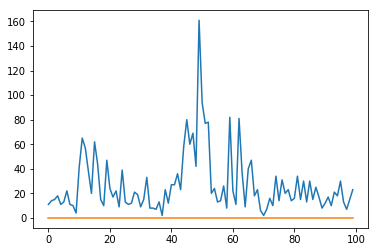

In [29]:
print(mse(preds[:, 1:],arr[:, 1:]))
plt.plot(arr[1][:100])
plt.plot(preds[1][:100])
plt.show()

mean:  29632.32181818182 | pred_mean:  10040.918181818182
var:  260362708.45097852 | pred_var:  6684107.286033059
correlation:
 actual vs predicted 
 [[1.         0.55560321]
 [0.55560321 1.        ]]


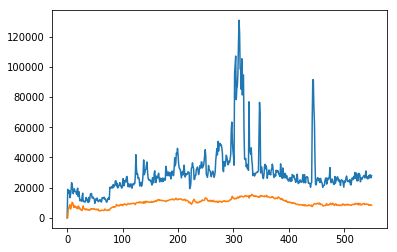

In [30]:
print("mean: ",np.mean(req_sum),"| pred_mean: ", np.mean(pred_req_sum))
print("var: ",np.var(req_sum),"| pred_var: ", np.var(pred_req_sum))
print("correlation:\n actual vs predicted \n", np.corrcoef(req_sum,pred_req_sum))

plt.plot(range(len(req_sum)),req_sum)
plt.plot(range(len(pred_req_sum)),pred_req_sum)

In [ ]:
preds[:][5]

Simple AE with 0.2 dimension

In [63]:
exp_avg = None
windows = [1]

for r, window in enumerate(windows):
    error = np.zeros(arr.shape[1])
    req_sum = np.zeros(arr.shape[1])
    pred_req_sum = np.zeros(arr.shape[1])
    preds = np.zeros((arr.shape[0], arr.shape[1]))
    encoding_dim = int(arr.shape[0]*0.8)
    input_shape = Input(shape=(content_type,))
    encoded = Dense(encoding_dim, activation='relu')(input_shape)
    decoded = Dense(content_type, activation='relu')(encoded)
    encoder = Model(input_shape, encoded)
    autoencoder = Model(input_shape, decoded)
    
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    autoencoder.compile(optimizer='adam', loss='mse')

    for w in range(window):
        preds[:, w] = 0
    for i in range(window, arr.shape[1]): # i -> timestep
        X = arr[:,i].reshape(1,content_type)
        print(X)
        p = autoencoder.predict(X)
        print(p)
        preds[:, i] = p.reshape(content_type)
        autoencoder.fit(X, X, epochs=200, verbose=0)
        req_sum[i] = np.sum(X)
        pred_req_sum[i] = np.sum(p,dtype=int)
        error[i] = mse(X,p)

[[11.0 14.0 0.0 13.0 0.0 7.0 0.0 26.0 23.0 3.0 0.0 1.0 5.0 0.0 27.0 17.0
  33.0 8.0 7.0 0.0 11.0 3.0 6.0 24.0 0.0 5.0 67.0 0.0 64.0 53.0 9.0 0.0
  10.0 4.0 30.0 29.0 2.0 0.0 0.0 4.0 9.0 6.0 7.0 5.0 6.0 4.0 9.0 42.0 0.0
  9.0 2.0 8.0 1.0 0.0 0.0 0.0 0.0 11.0 9.0 1.0 0.0 13.0 4.0 5.0 0.0 31.0
  0.0 2.0 0.0 1.0 0.0 3.0 34.0 0.0 1.0 18.0 10.0 5.0 0.0 5.0 0.0 0.0 0.0
  0.0 25.0 11.0 4.0 14.0 4.0 0.0 6.0 0.0 0.0 7.0 0.0 0.0 0.0 0.0 9.0 0.0]]
[[10.487493   11.070903   12.850404    0.          9.604204    0.8395084
  17.186768    0.         19.284788    0.          7.554284    2.5263152
   0.          0.          0.          0.          0.         10.772019
   0.          6.6914325   0.          5.309981    6.4092603   0.88944715
   0.          0.          1.7492744  15.200324    0.          0.
   0.         11.964362   29.226706    0.         11.876774    1.7823006
   0.          1.3910018   1.5457222   4.6006117  18.912552    0.
   0.          0.          0.         17.977007   14.29179    1

[[22.0 11.0 3.0 9.0 0.0 17.0 0.0 37.0 15.0 13.0 0.0 6.0 3.0 0.0 22.0 21.0
  195.0 9.0 11.0 0.0 17.0 15.0 64.0 8.0 0.0 5.0 33.0 0.0 10.0 9.0 8.0 2.0
  26.0 7.0 37.0 97.0 3.0 0.0 0.0 5.0 44.0 22.0 4.0 6.0 23.0 7.0 4.0 30.0
  0.0 18.0 22.0 16.0 0.0 0.0 0.0 0.0 2.0 29.0 8.0 4.0 0.0 64.0 4.0 8.0
  0.0 36.0 0.0 11.0 0.0 5.0 0.0 24.0 25.0 0.0 11.0 24.0 20.0 3.0 1.0 6.0
  5.0 0.0 0.0 0.0 16.0 8.0 10.0 19.0 25.0 0.0 23.0 0.0 3.0 10.0 0.0 0.0
  0.0 0.0 10.0 0.0]]
[[ 9.993185   7.5546     0.         0.         0.        18.221
   0.        29.0009     0.         0.         0.         0.
   0.         0.        40.813385  23.918232   0.         0.
  38.08683    0.        57.020767   5.2203918  7.469076   8.544803
   0.        11.506046  22.265396   0.         0.         0.
   0.         0.         0.         0.        16.348482   0.
   2.9646082  0.         0.         0.        57.128757  20.277784
   0.         0.         8.291577   0.         0.        50.616047
   0.         0.        31.790054

[[15.0 38.0 6.0 145.0 0.0 9.0 0.0 33.0 12.0 12.0 1.0 6.0 8.0 0.0 32.0
  28.0 28.0 17.0 231.0 0.0 21.0 7.0 48.0 19.0 0.0 6.0 37.0 0.0 17.0 14.0
  11.0 11.0 11.0 14.0 26.0 7.0 8.0 0.0 0.0 3.0 28.0 33.0 14.0 22.0 23.0
  11.0 10.0 27.0 0.0 6.0 16.0 32.0 1.0 2.0 3.0 0.0 1.0 20.0 13.0 5.0 0.0
  35.0 5.0 26.0 0.0 28.0 0.0 8.0 0.0 7.0 0.0 10.0 4.0 0.0 14.0 22.0 31.0
  10.0 1.0 3.0 5.0 0.0 0.0 0.0 10.0 45.0 5.0 14.0 16.0 0.0 19.0 0.0 3.0
  8.0 0.0 0.0 2.0 0.0 16.0 0.0]]
[[ 13.53285     87.868805     0.          33.751564     0.
    0.           0.          60.71746     32.1601       0.
    0.           0.           0.           0.          16.504429
   65.648605     0.           3.5403652   47.218285     0.
    0.60425574  50.98468     17.474844    50.965614     0.
   11.524923    60.268215     0.          18.538485     0.
    4.03544      6.951749     1.3216225   23.504469    37.292408
    0.           0.           0.           0.           0.
   81.80529     63.975887     0.           0.     

[[7.0 47.0 2.0 22.0 0.0 14.0 0.0 34.0 82.0 3.0 0.0 7.0 3.0 0.0 14.0 27.0
  101.0 5.0 15.0 0.0 11.0 11.0 45.0 22.0 0.0 16.0 63.0 0.0 7.0 33.0 2.0
  23.0 8.0 23.0 13.0 1.0 14.0 0.0 0.0 2.0 25.0 19.0 2.0 4.0 15.0 1.0 2.0
  54.0 0.0 7.0 11.0 12.0 0.0 0.0 0.0 0.0 0.0 48.0 14.0 48.0 0.0 8.0 0.0
  23.0 0.0 70.0 0.0 1.0 0.0 0.0 0.0 8.0 16.0 0.0 19.0 67.0 11.0 7.0 3.0
  8.0 0.0 0.0 0.0 0.0 26.0 30.0 7.0 7.0 6.0 0.0 22.0 0.0 3.0 6.0 0.0 0.0
  1.0 0.0 17.0 0.0]]
[[  2.4185283    2.5851202    0.           2.4456863    0.
    0.           0.          83.31438      0.           5.1307263
    0.           4.1621575    5.5181513    0.           0.
   16.443731    28.637568    21.904264     8.950166     0.
   14.376382     0.          37.224537     5.9422617    0.
    3.5756342   27.92328      0.           4.67797      0.
    0.           0.          10.446243    19.09191     10.334878
    0.           0.           0.           0.           6.342966
   38.05491      5.985255     5.031635     6.842477  

[[15.0 39.0 6.0 7.0 0.0 8.0 0.0 45.0 23.0 7.0 0.0 67.0 3.0 0.0 18.0 20.0
  107.0 14.0 31.0 0.0 14.0 6.0 12.0 14.0 0.0 7.0 62.0 0.0 14.0 6.0 14.0
  3.0 8.0 25.0 13.0 7.0 5.0 0.0 0.0 5.0 28.0 32.0 9.0 8.0 19.0 12.0 9.0
  37.0 0.0 13.0 3.0 18.0 0.0 0.0 1.0 1.0 0.0 19.0 5.0 63.0 0.0 87.0 10.0
  24.0 0.0 22.0 0.0 17.0 0.0 6.0 0.0 13.0 4.0 0.0 10.0 52.0 14.0 17.0 3.0
  2.0 0.0 0.0 0.0 0.0 52.0 32.0 13.0 6.0 9.0 0.0 10.0 0.0 6.0 7.0 0.0 0.0
  0.0 0.0 103.0 0.0]]
[[16.1928     7.294962   0.         0.         0.         0.
   0.         7.9038954 13.824861   0.         0.         0.
   8.682706   0.        30.994524  10.248246  67.08563   12.66793
  39.99696    0.        30.7117    10.77925    0.        24.712496
   0.         9.984214  56.267784   0.        20.432732   6.5716577
  16.868544  17.684048  10.659981  11.211538   8.292049   0.
   8.85303    0.         0.         0.         8.416773  23.502844
  12.23512    0.        62.51911    0.         8.6179285 50.06461
   0.        19.887375 

[[8.0 9.0 3.0 14.0 0.0 9.0 0.0 115.0 13.0 10.0 1.0 19.0 2.0 0.0 10.0 14.0
  82.0 5.0 49.0 0.0 10.0 10.0 14.0 40.0 0.0 16.0 35.0 0.0 14.0 3.0 3.0
  2.0 5.0 4.0 17.0 28.0 1.0 0.0 0.0 5.0 21.0 14.0 8.0 5.0 4.0 4.0 0.0
  46.0 0.0 1.0 3.0 10.0 0.0 0.0 0.0 0.0 0.0 18.0 5.0 63.0 0.0 4.0 4.0
  11.0 0.0 79.0 0.0 7.0 0.0 3.0 0.0 10.0 3.0 0.0 5.0 27.0 16.0 5.0 1.0
  1.0 1.0 0.0 0.0 0.0 13.0 22.0 7.0 3.0 6.0 0.0 5.0 0.0 3.0 5.0 0.0 0.0
  1.0 0.0 21.0 0.0]]
[[ 8.2602005 17.978031   0.         7.611549   0.         0.
   0.         6.5624146  1.3778387  0.         0.         4.548301
   5.28424    0.         9.05037   15.010722   4.164339   0.
  38.2072     0.        12.244944   0.        29.447542  17.621992
   0.         0.        49.806725   0.         0.         0.
   0.         0.         0.         0.         5.397101   0.
   3.9241838  0.         0.         0.        25.075623  10.0159445
   0.         0.         1.5533805  2.25836    5.7344503 25.799532
   0.         0.         0.        12.

[[7.0 13.0 2.0 7.0 0.0 3.0 0.0 63.0 93.0 9.0 0.0 26.0 2.0 0.0 12.0 10.0
  5.0 6.0 57.0 0.0 8.0 5.0 14.0 11.0 0.0 7.0 6.0 0.0 11.0 8.0 2.0 2.0 6.0
  3.0 11.0 4.0 6.0 0.0 0.0 0.0 51.0 11.0 4.0 2.0 9.0 0.0 5.0 33.0 0.0
  10.0 9.0 7.0 0.0 0.0 2.0 0.0 1.0 13.0 4.0 15.0 0.0 101.0 4.0 3.0 0.0
  22.0 0.0 13.0 0.0 4.0 0.0 7.0 0.0 0.0 3.0 115.0 12.0 6.0 5.0 7.0 1.0
  0.0 0.0 0.0 6.0 15.0 19.0 9.0 11.0 0.0 28.0 0.0 3.0 2.0 0.0 0.0 2.0 0.0
  7.0 0.0]]
[[ 9.599442    5.7920113   0.         16.83089     0.          5.590439
   0.         45.844166   25.2336      0.          0.          2.430848
   0.          0.         24.290438   13.47965    57.589714   14.041736
  23.705242    0.          0.         11.733711   18.680206    9.729681
   0.          2.1146557  58.058853    0.          0.          0.
  15.09412     0.          0.          0.         22.763227    0.
   0.          0.          0.          0.         39.55025    15.359175
   0.          0.         24.563911    0.52851963  0.         24

[[9.0 27.0 0.0 19.0 0.0 15.0 0.0 21.0 13.0 6.0 1.0 17.0 1.0 0.0 14.0 41.0
  14.0 7.0 6.0 0.0 25.0 6.0 11.0 27.0 0.0 11.0 30.0 0.0 16.0 6.0 18.0 3.0
  4.0 8.0 11.0 2.0 1.0 0.0 0.0 1.0 55.0 25.0 9.0 8.0 11.0 7.0 8.0 22.0
  0.0 31.0 5.0 6.0 0.0 0.0 0.0 0.0 1.0 10.0 11.0 3.0 0.0 19.0 5.0 9.0 0.0
  133.0 0.0 6.0 0.0 3.0 0.0 9.0 4.0 0.0 12.0 79.0 12.0 5.0 2.0 4.0 1.0
  0.0 0.0 0.0 10.0 8.0 8.0 7.0 10.0 0.0 7.0 0.0 0.0 4.0 0.0 0.0 0.0 0.0
  18.0 0.0]]
[[  0.          26.879045     7.661502    17.1492       0.
    5.6161575    0.          22.531925    19.063978     6.2196417
    0.           6.0313683    0.           0.          44.842216
    0.           0.           0.          10.426517     0.
   36.265263    11.943765    10.430442    15.252049     0.
    4.5910625  109.69652      0.           0.           2.1792948
    0.           0.           0.           0.           9.025549
    0.           0.           0.           0.           0.
   55.017487     0.           0.           0.        

[[15.0 69.0 6.0 47.0 0.0 7.0 0.0 37.0 13.0 5.0 0.0 4.0 6.0 0.0 16.0 4.0
  13.0 11.0 8.0 0.0 9.0 11.0 25.0 34.0 0.0 79.0 67.0 4.0 5.0 7.0 9.0 2.0
  12.0 5.0 5.0 8.0 5.0 0.0 0.0 11.0 26.0 39.0 3.0 12.0 19.0 7.0 11.0 18.0
  0.0 3.0 5.0 14.0 1.0 0.0 0.0 2.0 2.0 8.0 7.0 57.0 0.0 13.0 5.0 120.0
  0.0 92.0 0.0 5.0 0.0 6.0 0.0 6.0 5.0 0.0 9.0 15.0 20.0 12.0 0.0 5.0 4.0
  0.0 0.0 0.0 5.0 14.0 9.0 30.0 16.0 0.0 22.0 0.0 4.0 5.0 0.0 0.0 0.0 0.0
  25.0 0.0]]
[[ 13.429692  107.86473     0.          0.          0.          0.
    0.         18.701765   17.578672   26.8026      0.          0.
    0.          0.         27.838066   19.625193   76.08905     0.
    0.          0.         48.060337    0.         19.80897    53.123466
    0.          0.         18.672768    0.          0.          0.
    0.          0.          0.         33.55201    22.009014   18.530819
   14.560757    0.          0.          0.         33.450615   17.184702
    0.          0.          0.         11.445801    4.3930025 

[[3.0 20.0 0.0 8.0 0.0 7.0 0.0 86.0 24.0 10.0 0.0 6.0 4.0 0.0 10.0 374.0
  6.0 8.0 8.0 0.0 39.0 8.0 7.0 19.0 0.0 9.0 32.0 1.0 11.0 4.0 17.0 3.0
  7.0 15.0 8.0 2.0 6.0 0.0 0.0 3.0 15.0 11.0 4.0 0.0 8.0 5.0 4.0 28.0 0.0
  3.0 2.0 9.0 0.0 0.0 0.0 0.0 0.0 13.0 4.0 65.0 0.0 17.0 1.0 1.0 0.0 19.0
  0.0 3.0 0.0 8.0 0.0 4.0 1.0 0.0 6.0 5.0 7.0 6.0 1.0 2.0 37.0 0.0 0.0
  0.0 33.0 7.0 18.0 12.0 24.0 0.0 14.0 0.0 3.0 4.0 0.0 0.0 0.0 0.0 7.0
  0.0]]
[[ 13.564459    40.35233      0.          41.340187     0.
    0.           0.         203.33202     23.575914     0.
    0.           0.           0.           0.           0.
   13.043696     0.          19.33652     27.485855     0.
    0.          16.267105     5.1351333   34.194496     0.
    3.3952627   22.077028     0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.          12.735425     0.           0.           1.5360569
    0.           0. 

[[4.0 82.0 1.0 20.0 0.0 5.0 0.0 44.0 15.0 7.0 0.0 3.0 4.0 0.0 17.0 5.0
  27.0 7.0 18.0 0.0 3.0 2.0 11.0 16.0 0.0 10.0 12.0 1.0 4.0 5.0 6.0 3.0
  5.0 6.0 11.0 9.0 2.0 0.0 0.0 5.0 18.0 21.0 5.0 12.0 250.0 41.0 2.0 30.0
  0.0 3.0 3.0 9.0 0.0 0.0 2.0 0.0 1.0 25.0 5.0 113.0 0.0 9.0 7.0 5.0 0.0
  26.0 0.0 8.0 0.0 2.0 0.0 3.0 4.0 0.0 3.0 18.0 8.0 25.0 3.0 2.0 1.0 0.0
  0.0 0.0 10.0 15.0 7.0 37.0 8.0 0.0 9.0 0.0 0.0 4.0 0.0 0.0 0.0 0.0 10.0
  0.0]]
[[ 20.763876    18.537943     0.           9.078267     0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    3.26857      0.           0.          19.175411     0.
    0.           0.           0.           2.1357925    0.
    0.           0.51084715   0.           0.          22.64244
    0.           0.           8.909549     0.           0.
   73.49915      0.           0.           0.           8.525637
    0.           0.           0.           0.         143.9686
    0.   

[[11.0 9.0 6.0 23.0 0.0 18.0 0.0 9.0 7.0 6.0 0.0 9.0 6.0 0.0 14.0 10.0
  19.0 7.0 8.0 0.0 15.0 7.0 14.0 17.0 0.0 28.0 41.0 1.0 14.0 6.0 7.0 7.0
  6.0 6.0 25.0 241.0 3.0 0.0 0.0 8.0 23.0 15.0 10.0 7.0 46.0 6.0 6.0 25.0
  0.0 21.0 7.0 22.0 0.0 0.0 0.0 1.0 0.0 17.0 7.0 15.0 0.0 19.0 3.0 11.0
  0.0 25.0 0.0 18.0 0.0 2.0 0.0 12.0 7.0 0.0 9.0 14.0 17.0 12.0 3.0 7.0
  0.0 0.0 0.0 0.0 13.0 54.0 7.0 11.0 8.0 0.0 12.0 0.0 2.0 5.0 0.0 0.0 0.0
  0.0 9.0 0.0]]
[[0.0000000e+00 1.4776649e+01 0.0000000e+00 2.3619780e+01 0.0000000e+00
  0.0000000e+00 0.0000000e+00 2.1023754e+01 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 7.5377054e+00 4.4308258e+01 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.3350666e+01 1.8099602e+01 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.2947156e+02 0.0000000e+00 0.0000000e+00 

[[10.0 6.0 2.0 12.0 0.0 8.0 0.0 16.0 14.0 2.0 90.0 5.0 7.0 0.0 10.0 32.0
  12.0 4.0 5.0 0.0 8.0 13.0 31.0 10.0 0.0 8.0 18.0 7.0 8.0 6.0 0.0 7.0
  10.0 9.0 24.0 59.0 4.0 0.0 0.0 5.0 11.0 12.0 9.0 3.0 4.0 3.0 8.0 26.0
  0.0 9.0 6.0 6.0 0.0 0.0 0.0 0.0 0.0 16.0 1.0 12.0 0.0 9.0 2.0 18.0 0.0
  51.0 0.0 5.0 0.0 4.0 0.0 5.0 4.0 0.0 3.0 19.0 10.0 7.0 1.0 4.0 4.0 0.0
  0.0 0.0 16.0 13.0 12.0 8.0 77.0 0.0 5.0 0.0 3.0 4.0 0.0 0.0 1.0 0.0
  11.0 0.0]]
[[0.0000000e+00 1.5380106e+01 0.0000000e+00 2.4029457e+01 0.0000000e+00
  0.0000000e+00 0.0000000e+00 3.2553955e+01 0.0000000e+00 0.0000000e+00
  0.0000000e+00 3.7293506e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.0796284e+01 1.5155226e+01 1.1923892e+01 4.9233757e+01 0.0000000e+00
  5.3186016e+00 0.0000000e+00 6.9508138e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 8.2152700e+00 0.0000000e+00 2.7314959e+01 0.0000000e+00
  0.0000000e+00 0.0000000e+00 6.1173248e+00 0.0000000e+00 0.0000000e+00
  3.3395599e+01 0.0000000e+00 0.0000000e+00 0.00000

[[10.0 34.0 1.0 7.0 0.0 25.0 0.0 4.0 15.0 2.0 1.0 4.0 1.0 0.0 22.0 23.0
  31.0 5.0 86.0 0.0 49.0 6.0 30.0 5.0 0.0 7.0 30.0 0.0 6.0 10.0 10.0 1.0
  6.0 19.0 17.0 143.0 3.0 0.0 0.0 3.0 9.0 14.0 3.0 3.0 26.0 4.0 10.0 21.0
  0.0 26.0 5.0 12.0 0.0 0.0 0.0 0.0 1.0 106.0 3.0 5.0 0.0 20.0 2.0 3.0
  0.0 15.0 0.0 6.0 0.0 4.0 0.0 6.0 8.0 0.0 41.0 4.0 19.0 4.0 13.0 4.0 1.0
  0.0 0.0 0.0 9.0 22.0 5.0 4.0 12.0 0.0 16.0 0.0 1.0 109.0 0.0 0.0 0.0
  0.0 11.0 0.0]]
[[0.0000000e+00 1.3921550e-01 0.0000000e+00 1.8280401e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  4.0941529e+00 0.0000000e+00 1.1127951e+01 6.4145493e+01 0.0000000e+00
  7.3508215e+00 1.7579605e+01 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.6222986e+01 3.7879890e+01 0.0000000e+00 3.2638736e+00 2.3969265e+01
  0.0000000e+00 0.0000000e+00 8.2212601e+00 0.0000000e+00 0.0000000e+00
  2.3048668e+02 0.0000000e+00 0.0000000e+00 

[[24.0 14.0 1.0 12.0 0.0 16.0 0.0 11.0 23.0 14.0 1.0 6.0 2.0 0.0 26.0
  18.0 14.0 12.0 54.0 0.0 23.0 11.0 24.0 20.0 0.0 12.0 32.0 1.0 10.0 4.0
  7.0 3.0 12.0 4.0 29.0 217.0 0.0 0.0 0.0 8.0 46.0 24.0 8.0 6.0 15.0 4.0
  6.0 51.0 0.0 3.0 10.0 15.0 0.0 0.0 1.0 0.0 0.0 14.0 8.0 22.0 0.0 97.0
  9.0 25.0 0.0 43.0 0.0 10.0 0.0 2.0 0.0 12.0 1.0 0.0 12.0 46.0 75.0 15.0
  3.0 15.0 6.0 0.0 0.0 0.0 11.0 13.0 10.0 16.0 41.0 0.0 56.0 0.0 3.0 6.0
  0.0 0.0 2.0 0.0 19.0 0.0]]
[[1.0077208e-01 2.5781446e+01 5.9188838e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.6701578e+01 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 3.8053463e+01 0.0000000e+00
  0.0000000e+00 1.1482657e+01 2.1936216e+01 2.6367613e+01 0.0000000e+00
  1.8162260e+01 1.4808044e+02 7.4885482e-01 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 7.4443316e+00 0.0000000e+00 0.0000000e+00
  1.7526575e+02 4.7125545e-01 0.

[[14.0 13.0 8.0 15.0 0.0 9.0 0.0 5.0 7.0 19.0 2.0 9.0 6.0 0.0 35.0 25.0
  9.0 11.0 13.0 0.0 22.0 15.0 15.0 20.0 0.0 8.0 80.0 2.0 25.0 6.0 7.0 3.0
  6.0 15.0 43.0 60.0 1.0 0.0 0.0 2.0 78.0 19.0 29.0 7.0 10.0 4.0 5.0 52.0
  0.0 12.0 9.0 24.0 0.0 0.0 0.0 1.0 0.0 11.0 4.0 2.0 0.0 41.0 5.0 16.0
  1.0 41.0 0.0 15.0 0.0 2.0 0.0 3.0 3.0 0.0 15.0 21.0 68.0 7.0 2.0 5.0
  5.0 0.0 0.0 0.0 3.0 10.0 15.0 9.0 18.0 0.0 9.0 0.0 0.0 8.0 0.0 0.0 1.0
  0.0 18.0 0.0]]
[[ 5.108389  19.181156   0.        13.524443   0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.8260621 19.134665  13.701723   0.         8.026701
  14.505685   0.        11.971385  13.321628  15.011267  13.335957
   0.         6.6205096 22.432993   0.         5.5483027  5.2579885
   0.         0.         5.585792   7.6400275 94.26208   63.2836
   0.         0.         0.         8.8546505  0.        12.135348
   1.521437   0.         0.         0.         2.9091291 27.778006
   0.         0.         

[[10.0 12.0 3.0 8.0 0.0 12.0 0.0 44.0 16.0 10.0 88.0 6.0 0.0 0.0 45.0 9.0
  14.0 9.0 12.0 0.0 19.0 13.0 11.0 23.0 0.0 6.0 59.0 2.0 89.0 2.0 8.0 4.0
  4.0 10.0 54.0 29.0 3.0 0.0 0.0 3.0 29.0 23.0 2.0 5.0 34.0 1.0 8.0 80.0
  0.0 5.0 5.0 28.0 0.0 0.0 0.0 0.0 1.0 47.0 6.0 8.0 0.0 34.0 1.0 11.0 1.0
  58.0 0.0 19.0 0.0 10.0 0.0 4.0 6.0 0.0 4.0 95.0 65.0 9.0 2.0 14.0 0.0
  0.0 0.0 0.0 6.0 7.0 7.0 10.0 17.0 0.0 34.0 0.0 5.0 189.0 0.0 0.0 0.0
  0.0 16.0 0.0]]
[[  0.          5.948846    0.         13.206055    0.          0.
    0.          0.          0.          0.          0.          0.
    0.          0.        105.68617    35.883465   41.09733     0.
   78.06177     0.          0.          5.981847    0.         17.863829
    0.          1.3219613 116.454185    0.          0.         29.118906
    0.          0.          0.          0.         63.431038   31.919552
    0.          0.          0.          0.          0.         12.19092
    0.          0.         17.224947    0.          0

[[15.0 30.0 1.0 5.0 0.0 13.0 0.0 71.0 25.0 17.0 9.0 40.0 5.0 0.0 24.0
  22.0 35.0 11.0 22.0 0.0 12.0 20.0 14.0 23.0 0.0 11.0 76.0 3.0 22.0 9.0
  16.0 8.0 10.0 9.0 50.0 51.0 6.0 0.0 0.0 5.0 63.0 27.0 7.0 3.0 35.0 11.0
  10.0 41.0 0.0 8.0 13.0 19.0 1.0 0.0 0.0 0.0 0.0 36.0 6.0 142.0 0.0 39.0
  2.0 55.0 4.0 99.0 0.0 62.0 0.0 4.0 0.0 10.0 4.0 0.0 74.0 132.0 61.0
  10.0 3.0 6.0 2.0 0.0 0.0 0.0 10.0 10.0 9.0 7.0 15.0 0.0 185.0 0.0 1.0
  5.0 0.0 0.0 1.0 0.0 18.0 0.0]]
[[6.8166590e+00 2.5252512e+01 0.0000000e+00 0.0000000e+00 0.0000000e+00
  2.2665781e+01 0.0000000e+00 0.0000000e+00 1.2839218e+01 0.0000000e+00
  0.0000000e+00 1.5502260e+02 0.0000000e+00 0.0000000e+00 0.0000000e+00
  2.0151873e+01 0.0000000e+00 5.5803714e+00 3.2625626e+01 0.0000000e+00
  0.0000000e+00 6.9820571e+00 1.4050291e+01 3.9274593e+01 0.0000000e+00
  8.0200815e+00 6.1968620e+01 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 6.2064662e+00 0.0000000e+00 1.6835697e+00
  1.0519917e+01 0.0000000e+00 

[[11.0 20.0 3.0 8.0 0.0 30.0 0.0 43.0 32.0 14.0 4.0 15.0 2.0 0.0 51.0
  129.0 19.0 4.0 21.0 0.0 8.0 23.0 9.0 20.0 0.0 20.0 41.0 2.0 7.0 5.0 8.0
  5.0 5.0 7.0 26.0 5.0 21.0 0.0 0.0 5.0 33.0 19.0 3.0 2.0 22.0 4.0 7.0
  54.0 0.0 26.0 7.0 51.0 0.0 0.0 1.0 0.0 0.0 26.0 5.0 22.0 0.0 71.0 5.0
  15.0 2.0 52.0 0.0 8.0 0.0 6.0 0.0 12.0 1.0 0.0 99.0 28.0 84.0 7.0 3.0
  3.0 1.0 0.0 0.0 0.0 8.0 35.0 10.0 18.0 66.0 0.0 15.0 0.0 6.0 6.0 0.0
  0.0 0.0 0.0 10.0 0.0]]
[[  0.          0.          0.          0.          0.          0.
    0.         65.99921    15.389346    0.          0.        114.1664
    0.          0.         41.615845    0.          0.         13.328827
    5.0117836   0.          0.          9.515836    0.         13.069831
    0.          0.         28.58195     0.          0.          0.
    0.          0.          0.          0.          0.         26.47595
    0.          0.          0.          0.         22.759731   14.021313
    0.          0.          4.376171    0.       

[[9.0 16.0 5.0 15.0 0.0 8.0 0.0 14.0 28.0 12.0 1.0 13.0 6.0 0.0 39.0 83.0
  9.0 10.0 11.0 0.0 10.0 9.0 62.0 16.0 0.0 9.0 89.0 3.0 11.0 1.0 13.0 3.0
  24.0 5.0 16.0 39.0 9.0 0.0 0.0 9.0 17.0 21.0 4.0 8.0 14.0 8.0 4.0 37.0
  0.0 8.0 9.0 15.0 0.0 0.0 0.0 0.0 1.0 17.0 6.0 9.0 0.0 22.0 5.0 7.0 3.0
  44.0 0.0 14.0 0.0 7.0 0.0 4.0 7.0 0.0 79.0 30.0 102.0 4.0 3.0 10.0 2.0
  0.0 0.0 0.0 9.0 7.0 4.0 8.0 32.0 0.0 64.0 0.0 3.0 3.0 10.0 0.0 1.0 0.0
  20.0 0.0]]
[[  4.476237   22.653969    0.          0.          0.          0.
    0.         12.645468   23.093838    0.          0.         21.523905
    0.          0.         29.571072    0.          0.          0.
   32.47734     0.          0.          3.5285904  17.111132   18.044483
    0.          6.3115616  68.001015    0.          0.          0.
    0.          0.          0.          0.         25.14365    35.477024
    0.          0.          0.          0.         16.455555   17.694534
    0.          0.         25.739187    0.          0.

[[12.0 18.0 4.0 11.0 0.0 22.0 0.0 8.0 25.0 22.0 5.0 8.0 2.0 0.0 26.0 12.0
  10.0 3.0 15.0 0.0 23.0 5.0 11.0 21.0 0.0 5.0 149.0 0.0 10.0 3.0 17.0
  0.0 9.0 7.0 13.0 30.0 2.0 0.0 0.0 2.0 31.0 17.0 7.0 1.0 16.0 8.0 3.0
  32.0 0.0 11.0 7.0 9.0 0.0 0.0 0.0 0.0 0.0 50.0 1.0 15.0 0.0 46.0 4.0
  10.0 2.0 35.0 0.0 12.0 0.0 5.0 0.0 11.0 2.0 0.0 7.0 13.0 28.0 13.0 1.0
  4.0 6.0 0.0 0.0 0.0 9.0 10.0 5.0 12.0 11.0 0.0 17.0 0.0 1.0 8.0 6.0 0.0
  1.0 0.0 11.0 0.0]]
[[ 4.2679944 15.197549   0.         0.         0.        10.233529
   0.        10.565705  13.833634  17.882618   0.         9.839061
   0.         0.        43.487053  13.432454   0.         3.2794118
  13.894118   0.         0.        11.176646  26.288635  20.40527
   0.         7.8559723 64.2363     0.         3.9143963  0.
   0.         0.         0.         0.        13.42522   58.692432
   0.         0.         0.         0.        19.372416  15.585289
   4.7028317  0.         6.685214   0.         3.6214116 31.78481
   0.         8.

[[10.0 28.0 1.0 3.0 0.0 6.0 0.0 45.0 36.0 19.0 2.0 16.0 7.0 0.0 23.0
  147.0 17.0 3.0 13.0 0.0 8.0 17.0 10.0 26.0 0.0 13.0 82.0 1.0 13.0 5.0
  2.0 1.0 2.0 6.0 14.0 22.0 3.0 0.0 0.0 5.0 20.0 19.0 1.0 3.0 32.0 2.0
  1.0 35.0 0.0 5.0 7.0 26.0 0.0 0.0 0.0 0.0 0.0 28.0 6.0 11.0 0.0 28.0
  3.0 10.0 5.0 36.0 0.0 4.0 0.0 0.0 0.0 4.0 6.0 0.0 4.0 36.0 27.0 7.0 1.0
  4.0 1.0 0.0 0.0 0.0 5.0 3.0 10.0 14.0 22.0 0.0 117.0 0.0 4.0 2.0 11.0
  0.0 0.0 0.0 55.0 0.0]]
[[  0.          0.          0.          0.          0.         18.630781
    0.          8.814485   11.559966   18.909739    0.         13.860561
    0.          0.         13.344057  215.12695     0.          0.
    0.          0.          0.          2.5529337   0.          5.7527423
    0.          0.          0.          0.          6.269071    0.
    0.          0.         13.064821    0.          0.         14.000691
    0.          0.          0.          5.0615377  25.665092    0.
    0.          5.6288624   0.          0.          

[[24.0 11.0 6.0 6.0 0.0 12.0 0.0 15.0 70.0 14.0 1.0 11.0 5.0 0.0 25.0
  30.0 17.0 3.0 12.0 0.0 73.0 13.0 13.0 41.0 0.0 13.0 15.0 2.0 6.0 4.0
  18.0 3.0 6.0 6.0 7.0 40.0 5.0 0.0 0.0 5.0 69.0 21.0 5.0 1.0 15.0 16.0
  6.0 42.0 0.0 4.0 9.0 10.0 1.0 0.0 0.0 0.0 0.0 17.0 0.0 18.0 0.0 18.0
  17.0 18.0 15.0 52.0 0.0 11.0 0.0 3.0 0.0 9.0 4.0 0.0 9.0 10.0 45.0 5.0
  2.0 8.0 3.0 0.0 0.0 0.0 23.0 8.0 8.0 19.0 19.0 0.0 52.0 0.0 2.0 18.0
  68.0 0.0 0.0 0.0 24.0 0.0]]
[[  0.         18.829634    0.          0.          0.          0.
    0.         43.50548    64.476776   21.454407    0.         11.16018
    0.          0.         27.90358    58.240746    0.          0.
    8.718657    0.         13.077486    8.168517    0.         38.7475
    0.         29.381594   37.117928    0.         20.420223    0.
   12.149032    0.         10.624386    0.         10.039662   34.882393
    0.          0.          0.          9.191759    5.019154   26.46141
    0.          5.7663136  20.227802    0.          0

[[10.0 13.0 2.0 8.0 0.0 8.0 0.0 20.0 25.0 9.0 4.0 13.0 8.0 0.0 24.0 35.0
  51.0 5.0 3.0 0.0 30.0 10.0 12.0 41.0 0.0 20.0 31.0 2.0 12.0 2.0 5.0 4.0
  7.0 3.0 28.0 24.0 10.0 0.0 0.0 10.0 27.0 28.0 0.0 19.0 21.0 5.0 7.0
  33.0 0.0 11.0 7.0 8.0 0.0 0.0 0.0 0.0 0.0 16.0 4.0 39.0 0.0 92.0 6.0
  52.0 7.0 73.0 0.0 11.0 0.0 2.0 0.0 5.0 7.0 0.0 25.0 14.0 45.0 16.0 6.0
  5.0 3.0 0.0 0.0 0.0 10.0 14.0 18.0 15.0 23.0 0.0 147.0 0.0 2.0 2.0 13.0
  0.0 2.0 0.0 58.0 0.0]]
[[16.6069    26.187765   0.         0.         0.        16.035767
   0.         0.        46.164715   9.667282   0.         1.0556257
   0.         0.         0.        68.071335   0.         7.03326
  19.70081    0.        33.242313   0.         0.        28.449955
   0.         0.        35.014072   0.         0.         0.
   6.1326737  0.         0.         0.        18.53638    2.2889228
   0.         0.         0.         0.        97.565315   0.
   0.         0.         0.         0.         0.        67.87471
   0.        20.

[[47.0 11.0 3.0 15.0 0.0 4.0 0.0 6.0 20.0 21.0 3.0 14.0 1.0 0.0 38.0 8.0
  14.0 6.0 6.0 0.0 37.0 16.0 11.0 18.0 0.0 3.0 11.0 0.0 10.0 8.0 52.0
  16.0 7.0 23.0 11.0 50.0 1.0 0.0 0.0 7.0 98.0 36.0 8.0 4.0 7.0 30.0 3.0
  38.0 0.0 9.0 6.0 7.0 0.0 2.0 1.0 1.0 0.0 7.0 4.0 16.0 0.0 27.0 4.0 8.0
  4.0 44.0 0.0 12.0 0.0 3.0 0.0 10.0 3.0 0.0 74.0 38.0 34.0 16.0 1.0 9.0
  0.0 0.0 0.0 0.0 20.0 13.0 12.0 8.0 17.0 0.0 109.0 0.0 7.0 28.0 13.0 1.0
  0.0 1.0 11.0 0.0]]
[[12.830095   2.5177517  0.         3.1982703  0.         0.
   0.         2.8418732 16.89736   21.732515   0.        12.022777
   0.         0.         6.7633786  8.457392   0.         0.
   0.         0.         0.         6.407247   0.        39.70274
   0.        25.820202  43.373264   0.         8.28448    0.
  10.484431   0.         5.4372005  0.         0.        18.595629
   0.         0.         0.         0.        32.28831   14.486319
   0.         0.         9.098552   0.         0.        42.4911
   0.         5.4674263  0. 

[[15.0 18.0 2.0 12.0 0.0 12.0 0.0 1.0 15.0 23.0 5.0 11.0 0.0 0.0 24.0
  34.0 64.0 6.0 8.0 0.0 33.0 8.0 16.0 14.0 0.0 11.0 31.0 3.0 8.0 3.0 28.0
  2.0 12.0 7.0 41.0 6.0 20.0 0.0 0.0 10.0 52.0 30.0 5.0 7.0 34.0 12.0
  17.0 44.0 0.0 24.0 21.0 16.0 1.0 0.0 0.0 0.0 0.0 15.0 8.0 22.0 0.0
  170.0 8.0 14.0 2.0 49.0 0.0 12.0 0.0 3.0 0.0 6.0 2.0 0.0 8.0 75.0 44.0
  14.0 0.0 4.0 1.0 0.0 0.0 0.0 8.0 14.0 14.0 14.0 35.0 0.0 32.0 0.0 1.0
  6.0 34.0 2.0 0.0 20.0 12.0 0.0]]
[[  0.          0.          0.          0.          0.          2.709162
    0.          0.          0.         10.450354    0.          0.
    0.          0.          0.         11.730265   72.78297     0.
    0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.         13.416323    0.
    0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.        115.14465     0.
    0.          0.         22.516966    0.          0.        

[[11.0 14.0 4.0 6.0 0.0 11.0 0.0 37.0 59.0 21.0 2.0 6.0 6.0 0.0 27.0 9.0
  54.0 7.0 10.0 0.0 11.0 15.0 25.0 13.0 0.0 9.0 54.0 0.0 19.0 5.0 7.0 2.0
  5.0 8.0 17.0 9.0 1.0 0.0 0.0 2.0 54.0 21.0 2.0 2.0 14.0 6.0 31.0 26.0
  0.0 11.0 3.0 16.0 1.0 1.0 1.0 0.0 0.0 6.0 5.0 12.0 0.0 14.0 1.0 10.0
  3.0 39.0 0.0 15.0 0.0 4.0 0.0 2.0 16.0 0.0 10.0 41.0 39.0 17.0 1.0 5.0
  2.0 0.0 0.0 0.0 6.0 10.0 12.0 3.0 37.0 0.0 337.0 0.0 34.0 15.0 4.0 10.0
  2.0 0.0 11.0 0.0]]
[[  9.578356   20.318321    0.          0.          0.         32.153404
    0.        160.51225    91.97605    35.57098     0.          0.
    0.          0.          0.         68.80602     0.          0.
   29.67285     0.         36.90349     0.          0.          0.
    0.         59.169975    0.          0.         47.376915    0.
    0.          0.          0.          0.          0.         52.08791
    0.          0.          0.          0.         41.835926    0.
    0.          0.         34.563343    0.          0.        

[[22.0 8.0 3.0 10.0 0.0 5.0 0.0 25.0 42.0 15.0 3.0 3.0 6.0 0.0 21.0 11.0
  15.0 11.0 20.0 0.0 30.0 12.0 31.0 18.0 0.0 13.0 26.0 0.0 9.0 10.0 4.0
  2.0 5.0 10.0 27.0 53.0 3.0 0.0 0.0 9.0 14.0 28.0 4.0 2.0 18.0 5.0 4.0
  36.0 0.0 10.0 8.0 12.0 0.0 0.0 0.0 0.0 1.0 9.0 8.0 8.0 0.0 29.0 3.0
  32.0 2.0 45.0 0.0 2.0 0.0 2.0 0.0 11.0 4.0 0.0 55.0 13.0 28.0 7.0 0.0
  5.0 0.0 0.0 0.0 0.0 9.0 10.0 13.0 13.0 31.0 0.0 54.0 0.0 10.0 6.0 7.0
  4.0 0.0 0.0 10.0 0.0]]
[[13.480948   0.         0.8893644  0.         0.         0.
   0.        37.13761   12.094419   8.223378   0.         0.
   0.         0.        17.770933   0.        22.82021    0.
   5.8616314  0.         0.         0.         0.         0.
   0.         0.         0.         0.         9.799602   0.
  14.2118025  0.         0.         0.         0.         0.
   0.         0.         0.         0.        24.032427   0.
   0.         0.         5.1145945  0.         0.        37.271988
   0.         0.         0.        30.193682   0. 

[[12.0 15.0 1.0 10.0 0.0 14.0 0.0 38.0 44.0 16.0 4.0 8.0 1.0 0.0 48.0
  23.0 9.0 16.0 6.0 0.0 12.0 6.0 11.0 26.0 0.0 16.0 23.0 1.0 20.0 4.0
  23.0 2.0 3.0 5.0 17.0 8.0 3.0 0.0 0.0 4.0 44.0 10.0 10.0 54.0 34.0 7.0
  7.0 36.0 0.0 8.0 19.0 19.0 0.0 1.0 1.0 0.0 0.0 46.0 13.0 19.0 0.0 39.0
  4.0 8.0 2.0 80.0 0.0 15.0 0.0 3.0 0.0 8.0 4.0 0.0 9.0 20.0 31.0 13.0
  1.0 5.0 1.0 0.0 0.0 0.0 12.0 14.0 26.0 15.0 18.0 0.0 38.0 0.0 13.0 7.0
  288.0 4.0 1.0 0.0 9.0 0.0]]
[[ 12.2748995   11.023635     0.           0.           0.
    0.           0.          28.033       29.421858     0.
    0.           0.           0.           0.           0.
    0.           0.           0.         102.60321      0.
    0.20765153   0.           0.          26.246845     0.
   26.14486      0.           0.          27.71626      0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
   90.37181     17.414919     0.           0.           0.
    0.   

[[8.0 6.0 5.0 15.0 0.0 7.0 0.0 88.0 39.0 18.0 5.0 10.0 5.0 0.0 27.0 14.0
  11.0 13.0 349.0 0.0 10.0 12.0 11.0 22.0 0.0 11.0 8.0 2.0 38.0 7.0 3.0
  5.0 8.0 10.0 16.0 10.0 6.0 0.0 0.0 6.0 115.0 31.0 8.0 5.0 14.0 6.0 2.0
  33.0 0.0 7.0 6.0 24.0 0.0 0.0 0.0 0.0 0.0 10.0 5.0 33.0 0.0 12.0 8.0
  7.0 4.0 46.0 0.0 11.0 0.0 5.0 0.0 12.0 0.0 0.0 17.0 15.0 25.0 7.0 0.0
  6.0 1.0 0.0 0.0 0.0 7.0 10.0 26.0 11.0 18.0 1.0 26.0 0.0 4.0 7.0 13.0
  9.0 2.0 0.0 19.0 0.0]]
[[1.00449991e+01 1.37499100e+02 1.95642397e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 3.69655304e+01
  1.77026253e+01 0.00000000e+00 0.00000000e+00 3.09653616e+00
  0.00000000e+00 0.00000000e+00 1.89788933e+01 2.03833141e+01
  1.53611965e+01 1.76533566e+01 8.09901352e+01 0.00000000e+00
  7.15591550e-01 2.78186169e+01 0.00000000e+00 1.14441242e+01
  0.00000000e+00 0.00000000e+00 6.36669588e+00 0.00000000e+00
  2.19273033e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.39079332e+00 5.35734463e+00

[[36.0 8.0 1.0 12.0 0.0 17.0 0.0 18.0 40.0 28.0 5.0 5.0 0.0 0.0 37.0 16.0
  26.0 11.0 10.0 0.0 16.0 8.0 10.0 19.0 0.0 18.0 18.0 3.0 19.0 2.0 23.0
  5.0 12.0 2.0 17.0 78.0 6.0 0.0 0.0 7.0 37.0 29.0 10.0 4.0 27.0 13.0 8.0
  39.0 0.0 8.0 14.0 9.0 0.0 1.0 0.0 0.0 1.0 17.0 6.0 7.0 0.0 64.0 23.0
  6.0 11.0 55.0 0.0 15.0 0.0 4.0 0.0 10.0 5.0 0.0 57.0 28.0 22.0 9.0 1.0
  6.0 4.0 0.0 0.0 0.0 6.0 12.0 9.0 7.0 53.0 0.0 20.0 0.0 2.0 3.0 9.0 2.0
  0.0 0.0 17.0 0.0]]
[[ 0.         0.         4.6036797  0.         0.         0.
   0.         9.884932  20.104996   0.         0.         0.
   0.         0.        19.335548  33.940235   0.         8.72174
  26.101355   0.         2.8684635  4.9593477 20.611013  31.561222
   0.         5.549635  44.67545    0.         9.753412   4.522172
  31.250385   0.         0.         0.         0.        68.55438
   0.         0.         0.         0.        18.138163   0.
   0.         0.        15.308568   0.         0.        39.644997
   0.         0.        10

[[27.0 6.0 3.0 4.0 0.0 13.0 0.0 11.0 46.0 23.0 5.0 8.0 2.0 0.0 44.0 18.0
  18.0 10.0 18.0 0.0 9.0 15.0 11.0 30.0 0.0 11.0 7.0 0.0 13.0 4.0 2.0 6.0
  8.0 4.0 7.0 13.0 1.0 0.0 0.0 10.0 14.0 18.0 1.0 3.0 31.0 4.0 4.0 43.0
  0.0 5.0 8.0 12.0 1.0 0.0 0.0 0.0 0.0 11.0 2.0 30.0 0.0 15.0 15.0 11.0
  3.0 46.0 0.0 9.0 0.0 3.0 0.0 7.0 6.0 0.0 68.0 16.0 33.0 8.0 2.0 5.0 0.0
  0.0 0.0 2.0 11.0 32.0 1.0 7.0 28.0 0.0 30.0 0.0 2.0 20.0 2.0 3.0 0.0
  83.0 6.0 0.0]]
[[ 34.552605    0.          6.5599008   1.1026487   0.          0.
    0.          0.         39.825874    9.989235    0.          0.
    0.          0.         21.16418     0.          0.          7.223939
   27.41236     0.          5.0651436  19.706104   18.196644   14.298157
    0.          5.544869    1.9496756   0.          9.226187    1.6404283
   12.571361    0.          3.1176946   0.          0.8561117  64.32297
    0.          0.          0.          0.         10.042806    6.774329
    8.653561    0.         34.627747    0.      

[[26.0 12.0 2.0 9.0 0.0 10.0 0.0 19.0 27.0 13.0 3.0 4.0 2.0 0.0 34.0 13.0
  10.0 8.0 25.0 0.0 9.0 14.0 55.0 19.0 0.0 12.0 8.0 1.0 7.0 5.0 26.0 24.0
  7.0 4.0 9.0 7.0 3.0 0.0 0.0 7.0 331.0 19.0 30.0 13.0 10.0 7.0 5.0 40.0
  0.0 6.0 12.0 13.0 0.0 0.0 0.0 0.0 0.0 22.0 6.0 12.0 0.0 19.0 5.0 14.0
  10.0 45.0 0.0 11.0 0.0 2.0 0.0 6.0 9.0 0.0 208.0 27.0 23.0 16.0 1.0 4.0
  1.0 0.0 0.0 3.0 8.0 28.0 7.0 30.0 44.0 0.0 61.0 0.0 3.0 1.0 126.0 4.0
  0.0 31.0 6.0 0.0]]
[[ 16.47837    41.36349     0.          0.          0.          0.
    0.         22.129683   30.946653   38.147545    0.          0.
    0.          0.         85.67896     0.        130.41916     0.
    9.551722    0.          0.         18.40142     0.         49.012108
    0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.        109.90645     0.
    0.          0.          0.          0.          0.         64

[[19.0 14.0 3.0 7.0 0.0 14.0 0.0 33.0 21.0 27.0 2.0 11.0 2.0 0.0 99.0
  15.0 43.0 15.0 196.0 0.0 10.0 16.0 13.0 32.0 0.0 13.0 13.0 2.0 8.0 4.0
  26.0 2.0 20.0 4.0 50.0 28.0 3.0 0.0 0.0 5.0 33.0 25.0 3.0 6.0 39.0 9.0
  4.0 45.0 0.0 6.0 7.0 27.0 0.0 0.0 0.0 0.0 0.0 18.0 8.0 9.0 0.0 37.0 4.0
  23.0 2.0 49.0 0.0 24.0 0.0 5.0 0.0 6.0 6.0 0.0 43.0 14.0 30.0 17.0 7.0
  6.0 3.0 0.0 0.0 3.0 13.0 22.0 6.0 9.0 30.0 0.0 74.0 0.0 7.0 6.0 9.0 4.0
  1.0 6.0 12.0 0.0]]
[[  8.255787     0.           0.           1.6880982    0.
    0.           0.          74.20494     39.921978    21.484718
    0.           0.           0.           0.         106.20775
   21.769928    10.400665     9.293112    28.103436     0.
   11.087063    14.914799     0.23341289  18.446262     0.
    0.          84.655464     0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
   53.991066     0.4092204    0.           0.           2.0

[[14.0 24.0 3.0 10.0 0.0 13.0 0.0 39.0 30.0 36.0 0.0 13.0 4.0 0.0 43.0
  33.0 33.0 9.0 38.0 0.0 22.0 18.0 11.0 32.0 0.0 16.0 19.0 3.0 10.0 4.0
  38.0 3.0 5.0 20.0 26.0 21.0 4.0 0.0 0.0 19.0 130.0 37.0 10.0 1.0 57.0
  11.0 7.0 57.0 0.0 12.0 12.0 22.0 1.0 0.0 0.0 0.0 0.0 14.0 11.0 34.0 0.0
  89.0 4.0 20.0 2.0 31.0 0.0 21.0 0.0 5.0 0.0 12.0 9.0 0.0 24.0 35.0 32.0
  7.0 1.0 9.0 3.0 0.0 0.0 0.0 39.0 16.0 23.0 12.0 43.0 0.0 51.0 0.0 13.0
  6.0 22.0 16.0 2.0 5.0 14.0 0.0]]
[[ 22.589987     0.           0.           0.           0.
   24.539017     0.          87.79594     11.964375    28.246578
    0.           4.0185823    0.           0.          23.024588
   23.193043    35.577576    14.359422     0.           0.
    0.           9.102839     0.          83.51676      0.
    0.          11.715824     0.          17.100758     0.
    0.           7.258122     0.           3.5225446    9.333572
    0.           0.           0.           0.           0.
  114.34746     28.014801     0.       

[[26.0 15.0 0.0 8.0 0.0 14.0 0.0 99.0 31.0 31.0 13.0 48.0 4.0 0.0 86.0
  17.0 31.0 12.0 17.0 0.0 22.0 16.0 11.0 44.0 0.0 11.0 41.0 2.0 8.0 10.0
  13.0 5.0 12.0 9.0 9.0 15.0 10.0 0.0 0.0 20.0 64.0 34.0 17.0 12.0 63.0
  10.0 4.0 42.0 0.0 13.0 12.0 20.0 0.0 0.0 0.0 0.0 0.0 13.0 9.0 47.0 0.0
  28.0 4.0 12.0 5.0 46.0 0.0 17.0 0.0 26.0 0.0 14.0 9.0 0.0 124.0 14.0
  38.0 11.0 3.0 5.0 2.0 0.0 0.0 1.0 9.0 14.0 18.0 10.0 39.0 0.0 63.0 0.0
  8.0 8.0 94.0 17.0 0.0 24.0 25.0 0.0]]
[[  0.           0.           0.           7.576242     0.
   20.011658     0.          95.02164     19.769114    11.2946825
    0.           0.           0.           0.          29.646385
   30.281912   170.14388     13.298894     0.           0.
    2.1949549    6.6940975    0.          18.824162     0.
    0.          81.25555      0.           0.           0.
    0.           0.           0.           0.          12.09142
    0.           0.           0.           0.           0.
   82.9634      45.563923     0.     

[[32.0 39.0 3.0 50.0 0.0 11.0 0.0 29.0 50.0 23.0 16.0 8.0 3.0 0.0 43.0
  8.0 94.0 17.0 11.0 0.0 18.0 12.0 21.0 68.0 0.0 44.0 8.0 3.0 20.0 6.0
  48.0 1.0 4.0 8.0 26.0 14.0 4.0 0.0 0.0 17.0 79.0 12.0 10.0 2.0 42.0 9.0
  7.0 52.0 0.0 8.0 60.0 29.0 0.0 0.0 0.0 0.0 0.0 10.0 12.0 109.0 0.0 50.0
  3.0 15.0 3.0 67.0 0.0 20.0 0.0 9.0 0.0 7.0 6.0 0.0 61.0 51.0 24.0 15.0
  0.0 4.0 7.0 0.0 0.0 4.0 11.0 57.0 35.0 23.0 29.0 0.0 65.0 0.0 1.0 6.0
  85.0 8.0 0.0 5.0 16.0 0.0]]
[[  3.9754071  19.018444    0.         13.565736    0.         25.938284
    0.         22.440105   26.78151    14.503052    0.          0.
    0.          0.          0.         17.975853   22.61175    22.475307
    0.          0.         13.563782   13.446632    0.         30.097805
    0.          1.7741443 126.322075    0.          0.          0.
    0.          0.          0.          0.         17.854359    0.
    0.          0.          0.          0.         39.683975   71.55903
    0.          8.251977   50.983013    0. 

[[9.0 76.0 4.0 9.0 0.0 11.0 0.0 23.0 33.0 28.0 9.0 13.0 2.0 0.0 36.0 20.0
  21.0 9.0 11.0 0.0 27.0 13.0 17.0 21.0 0.0 11.0 21.0 3.0 9.0 12.0 10.0
  0.0 6.0 4.0 11.0 9.0 10.0 0.0 0.0 12.0 62.0 37.0 11.0 11.0 77.0 36.0
  11.0 49.0 0.0 7.0 13.0 19.0 0.0 0.0 0.0 1.0 1.0 32.0 12.0 67.0 0.0 13.0
  10.0 18.0 16.0 37.0 0.0 15.0 0.0 6.0 0.0 10.0 6.0 0.0 43.0 26.0 34.0
  14.0 3.0 1.0 4.0 0.0 0.0 2.0 11.0 23.0 61.0 17.0 40.0 0.0 22.0 0.0 7.0
  11.0 13.0 57.0 1.0 11.0 17.0 0.0]]
[[ 19.031982  18.686718   7.235578  26.4313     0.        17.26836
    0.        22.92975   31.64978   12.149477   0.         0.
    0.         0.        46.8755    31.471395  61.30201    9.002599
   37.232975   0.        34.66088   12.952731   0.        37.12348
    0.        19.081467  41.979237   0.        12.203905  14.018032
   29.130692   0.        13.65215    0.        22.97295    0.
    0.         0.         0.         0.        63.62173   49.618645
    0.        15.09208   61.495785   0.         0.        74.87905

[[15.0 17.0 3.0 14.0 0.0 13.0 0.0 24.0 47.0 17.0 7.0 18.0 2.0 42.0 30.0
  13.0 25.0 2.0 38.0 0.0 12.0 16.0 16.0 37.0 0.0 16.0 52.0 3.0 8.0 6.0
  21.0 1.0 7.0 7.0 4.0 14.0 9.0 0.0 0.0 10.0 57.0 27.0 8.0 3.0 36.0 12.0
  8.0 26.0 0.0 7.0 7.0 21.0 0.0 0.0 0.0 0.0 10.0 24.0 7.0 89.0 0.0 23.0
  6.0 16.0 5.0 38.0 0.0 35.0 0.0 5.0 0.0 8.0 10.0 0.0 39.0 16.0 33.0 10.0
  0.0 5.0 6.0 0.0 0.0 3.0 22.0 19.0 6.0 5.0 29.0 0.0 74.0 0.0 6.0 13.0
  37.0 39.0 0.0 16.0 16.0 0.0]]
[[  8.181929   29.065386    6.888824   13.514202    0.         15.711671
    0.         42.014225   38.14937    36.7525      0.          0.
    0.          0.         48.995564   28.360823   19.297363    3.293665
   25.900953    0.         14.1616745  18.310701    0.6161734  23.489254
    0.         11.257045   54.848793    0.         18.072071   14.893734
   20.741634    0.          3.9661918   9.807364   35.911842    0.
    0.          0.          0.          0.         41.704872   39.354614
    0.         12.898411   38.837402

[[26.0 11.0 1.0 6.0 0.0 9.0 0.0 43.0 24.0 21.0 7.0 12.0 3.0 21.0 18.0
  24.0 20.0 5.0 11.0 0.0 9.0 8.0 13.0 21.0 0.0 14.0 31.0 3.0 6.0 15.0
  26.0 4.0 9.0 8.0 10.0 8.0 7.0 0.0 0.0 8.0 31.0 20.0 3.0 10.0 121.0 8.0
  73.0 34.0 0.0 7.0 11.0 26.0 0.0 0.0 1.0 0.0 1.0 10.0 8.0 354.0 0.0 20.0
  4.0 7.0 3.0 93.0 0.0 28.0 0.0 12.0 0.0 10.0 5.0 0.0 275.0 23.0 27.0
  17.0 2.0 8.0 3.0 0.0 0.0 2.0 12.0 33.0 7.0 8.0 29.0 0.0 57.0 0.0 4.0
  18.0 26.0 44.0 2.0 4.0 15.0 0.0]]
[[  0.          0.          0.         47.66873     0.          7.7034793
    0.         32.49046    68.501144   27.77837     0.          0.
    0.          0.         55.361736    0.          0.         13.770738
    4.1096478   0.          0.         13.727693    0.         25.929258
    0.          0.         13.902033    0.          0.          4.0074105
   35.11772     0.          0.          0.          0.          0.
    0.          0.          0.          0.         57.9032     48.14963
    0.          0.        163.18909 

[[34.0 12.0 4.0 24.0 0.0 2.0 0.0 30.0 46.0 20.0 16.0 15.0 6.0 13.0 32.0
  33.0 159.0 10.0 11.0 0.0 28.0 10.0 24.0 27.0 0.0 12.0 32.0 0.0 13.0 1.0
  7.0 9.0 8.0 47.0 11.0 10.0 12.0 0.0 0.0 12.0 44.0 41.0 13.0 11.0 27.0
  18.0 1.0 50.0 0.0 7.0 13.0 19.0 1.0 1.0 0.0 0.0 2.0 52.0 5.0 158.0 0.0
  34.0 11.0 108.0 18.0 56.0 0.0 11.0 0.0 7.0 0.0 7.0 4.0 0.0 18.0 36.0
  32.0 9.0 0.0 7.0 5.0 0.0 0.0 3.0 12.0 14.0 16.0 17.0 27.0 0.0 45.0 0.0
  9.0 19.0 10.0 12.0 0.0 7.0 25.0 0.0]]
[[  0.          0.          0.          0.         20.853043    0.
    0.         20.332382   36.683537   24.134693   51.65334     0.
    0.          0.         21.088997    0.          0.          2.1636016
    0.          0.         22.106075   13.855443    3.7198997  66.06243
    0.         12.197698    0.          6.741363   11.462487    0.
    0.          0.          0.          0.          0.          0.
    0.          0.          0.          0.         22.475363    0.
   18.646557    6.3478684   0.         18.23

[[14.0 17.0 7.0 8.0 0.0 18.0 0.0 41.0 42.0 23.0 8.0 8.0 7.0 9.0 27.0 49.0
  15.0 4.0 29.0 0.0 19.0 16.0 17.0 23.0 0.0 11.0 18.0 17.0 14.0 7.0 15.0
  6.0 16.0 15.0 12.0 6.0 6.0 0.0 0.0 7.0 69.0 34.0 2.0 5.0 42.0 15.0 16.0
  37.0 0.0 26.0 10.0 10.0 0.0 0.0 1.0 0.0 0.0 11.0 13.0 457.0 0.0 115.0
  8.0 60.0 18.0 53.0 0.0 14.0 0.0 8.0 0.0 6.0 7.0 0.0 11.0 20.0 40.0 13.0
  0.0 9.0 50.0 0.0 0.0 2.0 14.0 11.0 8.0 9.0 25.0 0.0 73.0 0.0 8.0 8.0
  25.0 9.0 3.0 2.0 13.0 0.0]]
[[  3.548978     0.           0.           0.           0.
   21.205767     0.          14.926208   193.4112      15.393452
    0.           0.           0.           0.          37.148026
   40.53394      0.           2.8510678   14.315166     0.
    0.          15.256733     2.1943464   20.426752     0.
    4.2443357   34.613686     0.          11.802445     0.
   26.067844     0.64582884   0.          10.4208555    9.076473
    0.           0.           0.           0.           0.
   81.97877     15.939463     0.          

[[11.0 20.0 3.0 14.0 0.0 40.0 0.0 63.0 68.0 14.0 3.0 6.0 1.0 7.0 21.0
  11.0 8.0 9.0 9.0 0.0 13.0 20.0 10.0 31.0 0.0 9.0 13.0 1.0 19.0 5.0 26.0
  5.0 9.0 15.0 11.0 6.0 6.0 45.0 0.0 4.0 43.0 56.0 4.0 1.0 58.0 6.0 5.0
  33.0 0.0 5.0 8.0 14.0 0.0 0.0 0.0 0.0 0.0 80.0 5.0 192.0 0.0 99.0 5.0
  18.0 4.0 44.0 0.0 19.0 0.0 6.0 0.0 7.0 7.0 0.0 82.0 88.0 38.0 10.0 1.0
  3.0 1.0 0.0 0.0 2.0 8.0 10.0 5.0 8.0 55.0 0.0 38.0 0.0 8.0 6.0 15.0
  44.0 3.0 9.0 16.0 0.0]]
[[ 16.154535    0.          0.          4.6561155   0.         24.709263
    0.         46.906086   25.832253   28.345613    0.          0.
    0.          0.         38.659184   12.332006    0.         13.145972
    0.          0.         49.439392   10.442736   15.803234   10.9896145
    0.          8.21584    47.672714    0.         24.335775    0.
   33.037685    0.          0.          0.         18.582903    5.1007566
    0.          0.          0.          0.         13.86156    51.466343
    0.          0.         51.292717    0.

[[21.0 20.0 3.0 15.0 0.0 17.0 0.0 26.0 24.0 23.0 33.0 6.0 4.0 6.0 34.0
  15.0 107.0 13.0 21.0 0.0 10.0 14.0 12.0 27.0 0.0 22.0 22.0 1.0 9.0 6.0
  17.0 2.0 7.0 662.0 14.0 8.0 8.0 7.0 0.0 12.0 76.0 35.0 13.0 9.0 20.0
  8.0 8.0 114.0 0.0 27.0 14.0 32.0 1.0 0.0 1.0 0.0 0.0 19.0 4.0 248.0 0.0
  110.0 6.0 8.0 6.0 44.0 0.0 5.0 0.0 5.0 0.0 3.0 17.0 0.0 12.0 22.0 48.0
  9.0 0.0 1.0 1.0 0.0 0.0 2.0 30.0 9.0 60.0 21.0 17.0 0.0 81.0 0.0 3.0
  38.0 12.0 33.0 0.0 4.0 20.0 0.0]]
[[ 20.464342    0.          0.          0.          0.          0.
    0.         26.798368    0.         20.177673    0.          0.
    0.          0.         40.563377    0.          0.         16.824099
   70.181625    0.          0.         11.280628   12.388455   41.673576
    0.         16.10495     0.          0.          0.          0.
   18.64679     0.          0.        616.22375    18.163698    0.
    0.          0.          0.          0.         21.711987   41.970634
    0.          0.          6.171001    0.  

[[15.0 26.0 1.0 8.0 0.0 11.0 0.0 15.0 31.0 27.0 2.0 5.0 1.0 8.0 70.0 11.0
  16.0 6.0 22.0 0.0 36.0 6.0 10.0 27.0 0.0 8.0 24.0 18.0 16.0 5.0 15.0
  4.0 16.0 140.0 16.0 15.0 6.0 2.0 0.0 3.0 19.0 34.0 54.0 23.0 72.0 6.0
  12.0 49.0 0.0 4.0 7.0 18.0 0.0 0.0 0.0 0.0 0.0 25.0 8.0 76.0 117.0 93.0
  7.0 15.0 10.0 70.0 0.0 8.0 0.0 4.0 0.0 5.0 16.0 0.0 7.0 25.0 68.0 15.0
  2.0 0.0 18.0 0.0 0.0 15.0 9.0 12.0 31.0 11.0 28.0 0.0 37.0 0.0 5.0 29.0
  3.0 14.0 0.0 2.0 20.0 0.0]]
[[ 31.481134    0.          0.         16.93942     0.          9.129624
    0.         21.39761    39.88426    12.393855   18.766087    0.
    0.          0.         26.009356    0.          0.          0.
    3.6405125   0.          0.         16.622133   10.566899   12.377051
    0.         15.370477   49.26484     0.          1.7843863   0.
   25.293634    0.          0.        119.948456    9.009359    0.
    0.          0.          0.          0.         27.924967   30.41444
    0.          0.         28.875904    0.    

[[20.0 17.0 5.0 12.0 0.0 19.0 0.0 10.0 52.0 25.0 75.0 6.0 1.0 24.0 119.0
  8.0 14.0 8.0 10.0 0.0 14.0 17.0 95.0 21.0 0.0 8.0 17.0 6.0 12.0 10.0
  10.0 4.0 58.0 222.0 21.0 6.0 4.0 12.0 0.0 3.0 35.0 35.0 78.0 14.0 30.0
  8.0 10.0 100.0 0.0 3.0 8.0 17.0 0.0 0.0 0.0 0.0 0.0 29.0 10.0 192.0 2.0
  55.0 30.0 8.0 6.0 105.0 0.0 22.0 0.0 2.0 0.0 7.0 7.0 0.0 16.0 34.0 92.0
  21.0 2.0 3.0 2.0 0.0 84.0 3.0 19.0 5.0 34.0 12.0 19.0 0.0 14.0 0.0 4.0
  12.0 98.0 11.0 0.0 3.0 9.0 0.0]]
[[  9.620971    0.          0.          0.          0.         86.05563
    0.         17.398481   37.29077    26.590862   21.665379    0.
    0.         29.468962  177.4234     35.03949     0.          0.
    3.363158    0.          0.         27.696264   22.477852   27.901997
    0.         25.505293   41.307617    0.          0.          0.
   25.89882     0.         59.48246   181.97914    14.578245    0.
    5.1174154   0.          0.          0.         62.382732   13.1952715
   72.67148     0.          0.          

[[17.0 11.0 1.0 15.0 0.0 8.0 0.0 14.0 17.0 33.0 57.0 5.0 3.0 376.0 35.0
  24.0 200.0 12.0 11.0 0.0 6.0 15.0 11.0 18.0 0.0 13.0 20.0 7.0 13.0 4.0
  14.0 5.0 7.0 42.0 14.0 101.0 8.0 2.0 0.0 15.0 86.0 36.0 5.0 6.0 23.0
  51.0 12.0 30.0 0.0 4.0 12.0 18.0 0.0 0.0 1.0 0.0 0.0 13.0 11.0 34.0 0.0
  32.0 59.0 16.0 12.0 45.0 0.0 20.0 0.0 3.0 0.0 10.0 14.0 0.0 28.0 65.0
  23.0 8.0 4.0 9.0 10.0 0.0 32.0 9.0 9.0 8.0 25.0 15.0 14.0 0.0 19.0 0.0
  16.0 54.0 65.0 25.0 3.0 6.0 16.0 0.0]]
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 5.1924648e+00 3.2028464e+02 1.6115681e+01
  1.9281075e+01 0.0000000e+00 2.0102528e+01 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 9.5609217e+00 0.0000000e+00
  1.0523272e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.8607423e+02 0.00

[[6.0 46.0 3.0 9.0 0.0 11.0 0.0 54.0 24.0 25.0 11.0 9.0 3.0 191.0 27.0
  24.0 64.0 16.0 10.0 0.0 26.0 7.0 11.0 23.0 0.0 9.0 55.0 4.0 15.0 7.0
  9.0 4.0 5.0 8.0 9.0 14.0 3.0 7.0 0.0 8.0 21.0 39.0 12.0 12.0 28.0 11.0
  21.0 35.0 0.0 3.0 10.0 15.0 0.0 0.0 0.0 0.0 0.0 23.0 10.0 132.0 0.0
  25.0 12.0 15.0 40.0 57.0 0.0 19.0 0.0 5.0 0.0 11.0 3.0 0.0 29.0 28.0
  55.0 12.0 1.0 2.0 5.0 0.0 5.0 4.0 18.0 11.0 23.0 9.0 15.0 0.0 20.0 0.0
  12.0 18.0 25.0 15.0 1.0 8.0 11.0 0.0]]
[[ 19.165674    0.          0.          0.          0.          6.3554196
    0.          0.        110.51138    31.921423   27.14272     0.
   10.186812  134.57932    28.785051   12.390588   89.33045     5.9248433
    0.          0.          0.         16.819904   10.475259   34.18549
    0.         27.09716     0.          0.          0.          0.
   21.19405     0.          0.        194.80736    18.91904     0.
    0.          0.          0.          0.         34.65923    30.706678
    3.5439432   0.          0.      

[[11.0 17.0 10.0 10.0 0.0 9.0 0.0 14.0 24.0 28.0 3.0 4.0 3.0 33.0 28.0
  7.0 71.0 4.0 9.0 0.0 22.0 19.0 9.0 20.0 0.0 5.0 73.0 5.0 15.0 10.0 9.0
  4.0 10.0 299.0 14.0 29.0 3.0 1.0 0.0 12.0 58.0 24.0 3.0 7.0 50.0 14.0
  11.0 55.0 0.0 1.0 11.0 28.0 0.0 0.0 0.0 0.0 1.0 62.0 6.0 69.0 0.0 55.0
  4.0 7.0 106.0 42.0 0.0 27.0 0.0 5.0 0.0 7.0 13.0 0.0 80.0 16.0 51.0
  12.0 3.0 5.0 4.0 0.0 13.0 6.0 10.0 8.0 7.0 14.0 30.0 0.0 16.0 0.0 4.0
  9.0 22.0 30.0 2.0 5.0 12.0 0.0]]
[[ 4.907353   0.         0.         1.3187711  0.        11.649935
   0.         0.         0.         9.489314   0.         0.
   0.        56.583233  21.79057   24.48333   26.829256  14.542481
   0.         0.         6.64328    0.        14.044385  13.419058
   0.         3.0892007  0.         0.        13.071665   5.7780094
   6.987389   0.         5.475071  17.648327  18.14066    0.
  10.337101   0.         0.         0.        17.54609   18.330809
   0.         5.7979393  0.         0.        14.171637   0.
   0.         0

[[11.0 36.0 4.0 13.0 0.0 17.0 0.0 18.0 28.0 39.0 14.0 6.0 4.0 33.0 35.0
  24.0 13.0 19.0 10.0 0.0 15.0 9.0 23.0 22.0 0.0 10.0 40.0 3.0 17.0 8.0
  10.0 7.0 8.0 32.0 28.0 28.0 5.0 1.0 17.0 4.0 46.0 34.0 9.0 30.0 22.0
  43.0 12.0 57.0 0.0 11.0 13.0 25.0 0.0 0.0 0.0 0.0 1.0 13.0 9.0 74.0 0.0
  92.0 7.0 9.0 16.0 45.0 0.0 36.0 0.0 13.0 0.0 6.0 8.0 0.0 50.0 35.0 62.0
  11.0 4.0 8.0 8.0 0.0 42.0 3.0 22.0 23.0 21.0 9.0 18.0 0.0 47.0 0.0 2.0
  72.0 8.0 15.0 0.0 4.0 10.0 0.0]]
[[ 80.56273     0.          0.         19.004164    0.         22.310633
    0.          0.         38.806095   29.194408   32.574245    0.
    0.         48.05971    52.93871    16.323757   32.487476   12.408894
    0.          0.         32.41004    18.273981   22.18275    15.202116
    0.         12.739969  117.80203     0.         26.404154    6.998173
   31.940407    0.         12.397893   28.8024     53.294067    0.
    4.472936    0.          0.          0.         31.75158   104.59737
   14.561239    9.764994   11.5

[[13.0 18.0 155.0 23.0 0.0 18.0 0.0 23.0 28.0 14.0 6.0 6.0 3.0 18.0 50.0
  38.0 17.0 9.0 8.0 0.0 28.0 20.0 20.0 15.0 0.0 13.0 27.0 4.0 32.0 7.0
  46.0 2.0 10.0 117.0 35.0 44.0 5.0 1.0 3.0 7.0 42.0 29.0 5.0 8.0 14.0
  10.0 13.0 45.0 0.0 65.0 5.0 23.0 0.0 0.0 0.0 0.0 0.0 25.0 13.0 130.0
  0.0 164.0 5.0 10.0 13.0 111.0 0.0 16.0 0.0 7.0 0.0 6.0 23.0 0.0 42.0
  10.0 29.0 9.0 14.0 4.0 9.0 0.0 37.0 8.0 18.0 22.0 23.0 7.0 18.0 0.0
  17.0 0.0 6.0 9.0 3.0 11.0 2.0 5.0 16.0 0.0]]
[[  0.          18.454344     0.           0.19655389   0.
    0.           0.          27.632723    44.166557    23.96403
    0.           0.           0.           0.          43.526783
    0.          41.259686     0.           0.           0.
    8.185121    20.956135    16.91564     22.876299     0.
   11.9492855  124.1254       0.           0.           0.
   10.008719     0.           0.           0.          78.60106
   95.04872      0.           0.           0.           0.
    0.          35.99872      0.      

[[38.0 13.0 6.0 9.0 0.0 21.0 0.0 8.0 36.0 29.0 4.0 4.0 8.0 34.0 37.0 27.0
  204.0 13.0 110.0 0.0 41.0 22.0 15.0 19.0 0.0 9.0 130.0 22.0 44.0 11.0
  44.0 2.0 7.0 13.0 16.0 5.0 6.0 5.0 1.0 8.0 16.0 34.0 5.0 25.0 13.0 30.0
  13.0 77.0 0.0 6.0 11.0 23.0 0.0 0.0 0.0 0.0 0.0 23.0 10.0 175.0 0.0
  58.0 37.0 11.0 124.0 45.0 0.0 17.0 0.0 15.0 0.0 7.0 12.0 0.0 60.0 52.0
  22.0 12.0 5.0 9.0 101.0 0.0 27.0 33.0 7.0 119.0 13.0 9.0 119.0 0.0 14.0
  0.0 9.0 10.0 864.0 14.0 3.0 5.0 5.0 0.0]]
[[ 80.90914      0.           0.          34.772766     0.
   30.006521     0.           0.          25.787415    20.026817
    0.           0.           0.          37.110336     0.
    0.          75.75461      0.           0.           0.
   45.067448    16.395468    21.277807     0.           0.
   13.995693   249.09097      0.           0.           0.
   85.58546      0.           0.         101.88961     73.11217
    0.          19.654696     0.           0.           0.
    0.          34.751503     0.    

[[79.0 37.0 7.0 23.0 0.0 20.0 0.0 16.0 68.0 35.0 11.0 14.0 6.0 47.0 31.0
  35.0 55.0 7.0 16.0 0.0 16.0 17.0 18.0 20.0 0.0 11.0 58.0 10.0 32.0 17.0
  19.0 4.0 12.0 14.0 54.0 42.0 9.0 12.0 6.0 7.0 26.0 46.0 8.0 17.0 30.0
  49.0 9.0 60.0 0.0 15.0 21.0 28.0 0.0 0.0 1.0 0.0 0.0 23.0 16.0 46.0 0.0
  107.0 23.0 158.0 15.0 59.0 0.0 17.0 0.0 8.0 0.0 17.0 14.0 0.0 19.0 28.0
  46.0 15.0 2.0 7.0 3.0 0.0 3.0 28.0 13.0 43.0 14.0 19.0 38.0 1.0 27.0
  1.0 6.0 67.0 208.0 16.0 4.0 10.0 22.0 0.0]]
[[  0.           0.           0.           0.           0.
    4.8164854    0.           0.          49.727386    23.257185
    0.           0.           0.          44.453026     6.5108714
    2.5956235   49.312218     5.9400444   39.49118      0.
   11.558398     0.           3.9710965    0.           0.
    2.9607127   64.18693      0.          20.662333     0.
   21.382185     0.           0.           0.          57.915314
    0.           0.           0.           0.           0.
   15.0620985   58.177994

[[23.0 10.0 10.0 15.0 159.0 8.0 0.0 15.0 57.0 36.0 20.0 7.0 7.0 26.0 42.0
  16.0 110.0 47.0 26.0 0.0 16.0 13.0 29.0 34.0 0.0 15.0 156.0 13.0 21.0
  10.0 24.0 9.0 7.0 31.0 155.0 39.0 3.0 33.0 12.0 6.0 93.0 30.0 10.0 54.0
  53.0 33.0 9.0 53.0 0.0 12.0 17.0 24.0 0.0 0.0 0.0 0.0 0.0 30.0 35.0
  56.0 0.0 48.0 8.0 111.0 23.0 73.0 0.0 27.0 0.0 7.0 0.0 9.0 13.0 0.0
  35.0 41.0 60.0 13.0 3.0 9.0 1.0 0.0 2.0 9.0 16.0 23.0 18.0 14.0 20.0
  0.0 57.0 1.0 11.0 115.0 15.0 9.0 0.0 6.0 10.0 0.0]]
[[  0.         32.96202     0.          6.338894    0.          0.
    0.          0.         42.28253    19.837444    0.          0.
    0.          0.         42.017822    0.          0.          0.
   43.50196     0.         50.444275   11.936372   15.840647    0.
    0.          0.        153.71198     0.         25.424484    0.
   28.646437    0.          0.          0.         42.747517   12.254954
    0.          0.          0.          0.         31.017084   52.892986
    0.          0.         51.7182

[[31.0 17.0 6.0 14.0 9.0 23.0 0.0 32.0 26.0 19.0 13.0 11.0 6.0 21.0 38.0
  28.0 20.0 11.0 39.0 0.0 14.0 8.0 279.0 26.0 0.0 14.0 24.0 6.0 38.0 7.0
  32.0 4.0 6.0 175.0 214.0 56.0 11.0 2.0 8.0 13.0 88.0 50.0 15.0 9.0 15.0
  10.0 8.0 33.0 0.0 61.0 20.0 22.0 0.0 0.0 0.0 1.0 0.0 27.0 5.0 17.0 50.0
  18.0 13.0 9.0 28.0 79.0 0.0 23.0 0.0 10.0 0.0 12.0 19.0 0.0 15.0 125.0
  32.0 35.0 2.0 7.0 8.0 0.0 4.0 48.0 14.0 46.0 14.0 10.0 35.0 0.0 66.0
  1.0 5.0 16.0 9.0 43.0 0.0 7.0 26.0 0.0]]
[[  0.         43.033455    0.          5.952915    0.          0.
    0.          0.         44.361855   38.976875    0.          0.
    0.          0.         53.139412   47.30004     0.          0.
   20.650942    0.         33.446144   13.837465   13.174305   33.672215
    0.         75.727516   96.37319     0.         31.900639    0.
   73.697266    0.          0.          2.6836395 209.10878     0.
    0.          0.          0.          0.        173.45166    45.744
    0.          0.         43.06286    35

[[15.0 22.0 6.0 10.0 55.0 18.0 0.0 30.0 15.0 15.0 12.0 6.0 8.0 15.0 42.0
  14.0 31.0 8.0 9.0 0.0 60.0 13.0 37.0 35.0 0.0 13.0 88.0 17.0 14.0 10.0
  8.0 5.0 6.0 45.0 31.0 7.0 4.0 11.0 35.0 8.0 62.0 14.0 7.0 7.0 13.0 6.0
  11.0 38.0 0.0 8.0 5.0 16.0 2.0 1.0 0.0 0.0 1.0 14.0 7.0 18.0 26.0 30.0
  4.0 79.0 63.0 113.0 0.0 23.0 0.0 4.0 0.0 5.0 7.0 73.0 92.0 46.0 41.0
  9.0 9.0 5.0 0.0 0.0 7.0 89.0 13.0 52.0 9.0 7.0 38.0 2.0 61.0 5.0 5.0
  10.0 53.0 22.0 0.0 3.0 9.0 0.0]]
[[  0.         22.159954    0.          9.832098    0.          0.
    0.         24.652372   19.374119   32.406696    0.         11.382344
    0.         34.084568   18.022804   21.964184   65.12001     0.
   21.60058     0.         10.658855   11.378167    0.         20.037725
    0.         16.535763   64.79883     0.         18.015148    0.
   20.02193     0.          0.         65.02243    80.94762     0.
    0.          0.          0.          0.         34.770885   21.576456
    0.          0.         24.509777    1.23

[[20.0 16.0 1.0 10.0 4.0 16.0 0.0 24.0 34.0 23.0 17.0 17.0 2.0 14.0 29.0
  19.0 12.0 8.0 93.0 0.0 22.0 23.0 38.0 37.0 0.0 93.0 21.0 20.0 13.0 11.0
  44.0 4.0 8.0 18.0 14.0 8.0 4.0 39.0 24.0 6.0 32.0 29.0 7.0 7.0 17.0
  13.0 6.0 54.0 0.0 12.0 22.0 15.0 0.0 0.0 0.0 0.0 0.0 13.0 8.0 38.0 7.0
  19.0 8.0 10.0 35.0 90.0 0.0 20.0 0.0 4.0 0.0 10.0 1.0 272.0 32.0 55.0
  44.0 14.0 5.0 2.0 3.0 0.0 5.0 8.0 8.0 20.0 77.0 12.0 27.0 1.0 31.0 27.0
  9.0 15.0 43.0 10.0 1.0 8.0 23.0 0.0]]
[[3.49659882e+01 1.01406126e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.30325069e+01 0.00000000e+00 0.00000000e+00
  2.41538677e+01 1.64455490e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 2.03895378e+01 2.47832680e+01 2.51591969e+01
  2.95239983e+01 5.03578377e+00 0.00000000e+00 0.00000000e+00
  2.06440306e+00 1.54408693e+01 4.16164246e+01 1.97325401e+01
  0.00000000e+00 1.50027790e+01 1.39156866e+01 0.00000000e+00
  1.50697889e+01 1.94352889e+00 1.23690674e+02 0.00000000e+00
  6.79960108e+00 0.00000000e

[[22.0 23.0 4.0 10.0 6.0 14.0 0.0 50.0 35.0 38.0 14.0 8.0 7.0 24.0 53.0
  27.0 25.0 21.0 14.0 0.0 16.0 20.0 61.0 21.0 0.0 20.0 33.0 7.0 17.0 9.0
  13.0 45.0 9.0 45.0 49.0 26.0 10.0 27.0 11.0 13.0 32.0 31.0 9.0 12.0
  21.0 9.0 17.0 78.0 0.0 18.0 18.0 24.0 0.0 0.0 0.0 0.0 0.0 25.0 11.0
  29.0 8.0 24.0 11.0 20.0 28.0 86.0 0.0 22.0 0.0 8.0 0.0 14.0 9.0 148.0
  36.0 110.0 47.0 11.0 4.0 6.0 4.0 0.0 6.0 22.0 9.0 38.0 14.0 12.0 50.0
  3.0 278.0 16.0 13.0 25.0 18.0 24.0 2.0 6.0 11.0 0.0]]
[[ 50.02535    77.33472     0.          8.22276     0.         11.943276
    0.         23.53652    38.655174   24.861586    0.          0.
    0.         38.29161    33.19933    15.867912   17.884176    9.644346
   45.032764    0.         16.369493   15.30949    14.99955    27.977652
    0.         12.45414    23.229513    0.         18.66804     9.497807
   19.831165    0.         11.901821   36.292137   21.894985    0.
   11.07485     0.          0.          0.         64.06448    30.185995
    7.9042625  1

[[22.0 13.0 0.0 54.0 4.0 14.0 0.0 24.0 34.0 23.0 4.0 6.0 4.0 13.0 28.0
  20.0 23.0 11.0 19.0 0.0 21.0 15.0 29.0 21.0 0.0 32.0 16.0 10.0 17.0 9.0
  17.0 5.0 6.0 33.0 55.0 41.0 2.0 150.0 12.0 8.0 54.0 22.0 6.0 8.0 68.0
  12.0 6.0 54.0 0.0 15.0 26.0 18.0 1.0 0.0 0.0 0.0 1.0 12.0 8.0 40.0 6.0
  50.0 7.0 39.0 26.0 92.0 0.0 8.0 0.0 13.0 0.0 6.0 9.0 180.0 121.0 19.0
  32.0 18.0 4.0 6.0 4.0 0.0 22.0 9.0 16.0 17.0 13.0 11.0 20.0 0.0 14.0
  6.0 10.0 15.0 76.0 11.0 2.0 12.0 6.0 0.0]]
[[ 22.57243    24.355476    0.          9.006683    0.         27.570059
    0.        134.56508   102.20398    69.40699     0.          0.
    0.         24.759142   96.82083    59.77729    23.69205    16.646013
   42.122246    0.         62.306362   44.370422   33.205547   40.843815
    0.         58.342667    0.          0.        105.64477    24.921124
   35.671684   22.294214   12.009635   71.956696   36.702213    0.
   16.552507    0.          0.          0.         81.385506   57.639683
    0.          0.97952

[[15.0 10.0 6.0 12.0 3.0 20.0 0.0 24.0 32.0 38.0 7.0 7.0 2.0 22.0 40.0
  12.0 21.0 6.0 13.0 0.0 25.0 12.0 21.0 20.0 0.0 25.0 46.0 19.0 26.0 10.0
  18.0 8.0 12.0 26.0 15.0 19.0 4.0 32.0 14.0 56.0 140.0 48.0 14.0 9.0
  13.0 11.0 7.0 79.0 0.0 8.0 11.0 15.0 0.0 0.0 0.0 0.0 0.0 27.0 7.0 59.0
  32.0 103.0 14.0 14.0 54.0 66.0 0.0 19.0 0.0 11.0 0.0 5.0 9.0 167.0
  111.0 22.0 110.0 7.0 3.0 4.0 3.0 0.0 7.0 51.0 9.0 11.0 12.0 7.0 42.0
  1.0 20.0 10.0 8.0 39.0 51.0 19.0 1.0 6.0 60.0 0.0]]
[[ 62.198643   33.054714    0.         16.205032    0.         29.22123
    0.         22.525295    0.         48.101013    0.          0.
    0.         17.007492   52.23502    10.337773   22.771185    0.5267094
    0.          0.         24.635834   11.388893  292.55664    28.953985
    0.         27.496054    0.          0.          0.         10.707365
    8.493377    0.         22.794632  127.53919     0.          0.
    1.8396616   0.          0.          0.         49.465107   42.428146
    0.         25.4

[[20.0 18.0 5.0 6.0 8.0 21.0 0.0 19.0 19.0 30.0 5.0 12.0 2.0 3.0 39.0
  22.0 12.0 6.0 9.0 0.0 16.0 23.0 18.0 17.0 0.0 31.0 55.0 29.0 13.0 34.0
  17.0 0.0 6.0 19.0 14.0 16.0 4.0 14.0 15.0 12.0 32.0 23.0 5.0 21.0 13.0
  6.0 8.0 172.0 0.0 20.0 12.0 19.0 0.0 0.0 0.0 0.0 0.0 17.0 6.0 53.0 12.0
  24.0 6.0 7.0 13.0 54.0 0.0 4.0 0.0 6.0 0.0 8.0 7.0 71.0 23.0 64.0 107.0
  6.0 4.0 4.0 4.0 0.0 10.0 14.0 17.0 13.0 19.0 22.0 68.0 10.0 33.0 1.0
  20.0 28.0 10.0 5.0 1.0 9.0 16.0 0.0]]
[[ 0.         11.60972     0.         16.66135     0.         12.210064
   0.          0.         40.903767   19.850706    0.          0.
   0.          9.802209   44.139122    9.608903   32.34573     0.
  28.474041    0.          0.38958204  8.289257    0.         22.947544
   0.         21.517818   57.57222     0.         23.082277    3.6878936
  26.006754   12.34576    11.251783   80.283615    2.395811    0.
   0.          0.          0.          0.         79.97424    25.458925
   5.1482167  16.720016   25.489614   

[[17.0 15.0 5.0 11.0 7.0 9.0 0.0 11.0 30.0 33.0 6.0 10.0 4.0 18.0 35.0
  20.0 19.0 2.0 22.0 0.0 11.0 15.0 21.0 17.0 0.0 8.0 81.0 7.0 25.0 13.0
  13.0 12.0 10.0 747.0 24.0 9.0 13.0 23.0 8.0 9.0 29.0 24.0 5.0 10.0 13.0
  17.0 9.0 87.0 0.0 18.0 28.0 30.0 0.0 0.0 1.0 0.0 1.0 25.0 6.0 14.0 7.0
  49.0 12.0 21.0 15.0 82.0 0.0 18.0 0.0 7.0 0.0 12.0 12.0 183.0 57.0 16.0
  120.0 11.0 3.0 2.0 4.0 0.0 44.0 7.0 9.0 28.0 20.0 9.0 24.0 0.0 24.0
  31.0 15.0 13.0 13.0 4.0 2.0 6.0 34.0 0.0]]
[[0.00000000e+00 4.75721474e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.16502655e+02
  7.89552689e+01 6.00889091e+01 0.00000000e+00 3.59963150e+01
  3.88523636e+01 1.63532257e+01 1.31340303e+01 5.02573166e+01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  2.91140137e+01 5.53216820e+01 6.45992050e+01 2.99628315e+01
  0.00000000e+00 2.54098835e+01 1.15561119e+02 0.00000000e+00
  0.00000000e+00 2.49999294e+01 1.69017601e+01 0.00000000e+00
  6.94641304e+00 5.886964

[[11.0 10.0 5.0 10.0 3.0 34.0 0.0 141.0 34.0 25.0 2.0 38.0 7.0 16.0 36.0
  19.0 21.0 9.0 75.0 0.0 15.0 35.0 78.0 13.0 0.0 16.0 25.0 7.0 22.0 9.0
  17.0 10.0 9.0 172.0 13.0 53.0 5.0 27.0 13.0 5.0 83.0 85.0 8.0 8.0 12.0
  41.0 4.0 186.0 25.0 21.0 13.0 16.0 0.0 0.0 0.0 1.0 0.0 22.0 10.0 20.0
  5.0 44.0 5.0 54.0 29.0 48.0 0.0 22.0 0.0 9.0 0.0 10.0 7.0 26.0 22.0
  47.0 109.0 8.0 1.0 0.0 10.0 0.0 10.0 67.0 12.0 47.0 22.0 9.0 21.0 3.0
  29.0 4.0 18.0 14.0 28.0 13.0 1.0 6.0 14.0 0.0]]
[[0.00000000e+00 1.24039717e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.34549608e+01 0.00000000e+00 3.69398880e+01
  0.00000000e+00 2.47877350e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 1.94746227e+01 1.06616335e+01 1.40864115e+01
  2.45931091e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 6.42485123e+01 1.53965607e+01
  0.00000000e+00 1.37793183e-01 3.64830732e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 2.35121307e+01 0.00000000e+00
  6.54961109e+00 1.450

[[10.0 16.0 3.0 10.0 5.0 18.0 0.0 13.0 71.0 31.0 7.0 8.0 11.0 18.0 28.0
  33.0 39.0 12.0 10.0 0.0 10.0 25.0 23.0 25.0 0.0 18.0 27.0 24.0 19.0 9.0
  17.0 2.0 13.0 101.0 13.0 57.0 4.0 22.0 55.0 4.0 67.0 262.0 7.0 13.0
  23.0 53.0 4.0 90.0 7.0 8.0 16.0 25.0 0.0 0.0 0.0 0.0 1.0 47.0 9.0 19.0
  43.0 14.0 12.0 15.0 15.0 54.0 0.0 20.0 0.0 2.0 0.0 11.0 14.0 147.0 30.0
  19.0 89.0 24.0 5.0 4.0 4.0 0.0 23.0 12.0 9.0 11.0 19.0 6.0 60.0 2.0
  31.0 9.0 10.0 12.0 31.0 4.0 1.0 10.0 10.0 0.0]]
[[15.092044    4.7013907   0.          2.6564112   0.         12.558076
   0.          0.         10.726516   17.85616     0.          0.
   0.         13.469431   42.101177   11.471257   18.391226    0.
   1.2834251   0.          0.17394614 11.983044   11.10202    13.904009
   0.         10.668346   23.34865     0.          1.6636974   0.7975328
   6.9256024   5.496242    6.5531344  58.058838    0.          0.
  12.313712    0.          0.          0.         57.66449    72.664154
  29.94303     0.89468205  6.8

[[13.0 10.0 1.0 29.0 2.0 13.0 0.0 17.0 45.0 25.0 6.0 7.0 2.0 13.0 33.0
  71.0 24.0 7.0 24.0 0.0 19.0 13.0 14.0 19.0 0.0 15.0 49.0 49.0 23.0 13.0
  11.0 6.0 10.0 24.0 49.0 72.0 8.0 10.0 65.0 12.0 73.0 65.0 5.0 9.0 23.0
  11.0 8.0 72.0 35.0 6.0 21.0 22.0 0.0 1.0 1.0 0.0 0.0 19.0 12.0 17.0
  18.0 32.0 9.0 5.0 13.0 56.0 0.0 27.0 0.0 8.0 0.0 4.0 3.0 295.0 27.0
  49.0 75.0 14.0 6.0 3.0 5.0 0.0 24.0 15.0 29.0 24.0 23.0 10.0 16.0 1.0
  14.0 10.0 15.0 17.0 18.0 7.0 3.0 10.0 12.0 0.0]]
[[ 11.256823   10.438955    2.3823752 123.15091     0.          9.483785
    0.          0.         31.997688   15.90221     0.          0.
    0.         20.169191   23.105076   30.181128   11.729662    0.
   61.094524    0.         20.79334    14.884624    0.         20.417507
    0.         14.30134    24.259579    0.         25.755116    0.
   11.849215    2.389259    7.2617416  21.529743   60.636917    0.
    2.1728616   0.          0.          0.         98.41902    54.920288
   11.17493     7.9027233  17.02

[[62.0 14.0 1.0 54.0 2.0 12.0 0.0 27.0 33.0 38.0 23.0 5.0 5.0 10.0 23.0
  27.0 81.0 9.0 26.0 2.0 23.0 9.0 12.0 46.0 0.0 21.0 33.0 21.0 21.0 7.0
  7.0 9.0 11.0 15.0 18.0 74.0 6.0 34.0 152.0 7.0 37.0 91.0 17.0 17.0 13.0
  7.0 11.0 56.0 14.0 6.0 19.0 14.0 1.0 0.0 0.0 0.0 0.0 18.0 16.0 36.0
  11.0 32.0 13.0 25.0 11.0 42.0 134.0 14.0 0.0 12.0 0.0 16.0 12.0 107.0
  8.0 34.0 98.0 11.0 5.0 11.0 3.0 0.0 54.0 23.0 10.0 21.0 25.0 8.0 30.0
  3.0 21.0 8.0 13.0 73.0 22.0 7.0 1.0 3.0 37.0 0.0]]
[[ 77.26128    11.879914    0.         22.609118    0.         10.674873
    0.         56.424206   55.891834   29.894701   15.734505    0.
   12.160811   15.739541   33.39004    53.69094    35.949253    0.
   16.757048    0.         13.990334   14.232815   12.476391   44.516174
    0.         26.399263   25.091808    0.         21.559532    9.562188
   29.001904    0.          5.985352   26.410854   48.403316    0.
    8.413272    0.         57.402508    0.         75.058624   47.905205
   10.856769   39.9419

[[15.0 14.0 5.0 14.0 1.0 17.0 0.0 94.0 34.0 35.0 9.0 6.0 8.0 10.0 32.0
  41.0 73.0 19.0 29.0 2.0 13.0 21.0 13.0 33.0 0.0 15.0 33.0 26.0 22.0 8.0
  27.0 4.0 9.0 81.0 10.0 60.0 4.0 41.0 57.0 9.0 105.0 41.0 10.0 8.0 33.0
  22.0 11.0 56.0 23.0 5.0 12.0 19.0 0.0 0.0 0.0 0.0 0.0 18.0 15.0 25.0
  7.0 27.0 35.0 13.0 27.0 40.0 8.0 21.0 0.0 4.0 0.0 7.0 8.0 60.0 63.0
  17.0 46.0 13.0 4.0 12.0 4.0 0.0 10.0 14.0 27.0 41.0 15.0 14.0 25.0 26.0
  16.0 18.0 12.0 16.0 51.0 7.0 2.0 3.0 25.0 0.0]]
[[16.220867   17.099636    0.37307432 17.72803     0.         17.572487
   0.          1.0123107  28.245274   22.703       0.          0.
   9.622496   11.252697   26.695637   45.299232   58.3237      0.
  22.9612      0.         12.97481    22.197126   44.665573   34.29323
   0.         11.15801    74.7412      0.         19.783127    5.8259883
  18.924244    1.4806297  11.52947    70.48945    29.561436    0.
   7.7762656   0.         56.03138     0.         91.57521    31.2572
   7.8903847  12.006493   27.2616

[[12.0 15.0 4.0 15.0 3.0 9.0 61.0 35.0 35.0 30.0 25.0 6.0 5.0 13.0 40.0
  28.0 20.0 5.0 7.0 3.0 13.0 34.0 48.0 25.0 71.0 15.0 13.0 36.0 30.0 8.0
  14.0 7.0 5.0 83.0 99.0 10.0 6.0 31.0 203.0 11.0 27.0 44.0 10.0 12.0
  21.0 43.0 10.0 50.0 13.0 5.0 11.0 14.0 0.0 0.0 0.0 0.0 2.0 31.0 9.0
  85.0 5.0 21.0 17.0 57.0 16.0 36.0 182.0 25.0 0.0 4.0 0.0 4.0 11.0 61.0
  5.0 19.0 63.0 11.0 3.0 13.0 4.0 0.0 60.0 6.0 12.0 21.0 14.0 12.0 32.0
  71.0 45.0 25.0 21.0 13.0 16.0 8.0 2.0 5.0 25.0 0.0]]
[[ 25.162008   13.652158    0.          0.          0.          0.
    0.          0.          4.784401   14.218906   58.500782    0.
    0.          0.         20.474247    0.         10.992649    0.
    8.329854    0.          0.        140.70433     9.084697    5.8363934
    0.         22.796083    0.          0.          0.          0.
    0.          0.          0.          0.          0.          0.
    0.          0.        298.14764     0.          3.8856108  31.217283
    0.          0.          0.   

[[18.0 28.0 3.0 19.0 2.0 9.0 10.0 21.0 43.0 35.0 105.0 7.0 4.0 10.0 40.0
  22.0 95.0 11.0 13.0 15.0 20.0 16.0 14.0 26.0 9.0 15.0 10.0 122.0 24.0
  14.0 16.0 5.0 6.0 33.0 22.0 38.0 4.0 26.0 637.0 7.0 303.0 151.0 6.0
  16.0 151.0 21.0 7.0 54.0 5.0 5.0 12.0 16.0 0.0 0.0 1.0 1.0 0.0 25.0
  10.0 100.0 16.0 26.0 13.0 83.0 12.0 60.0 208.0 20.0 0.0 11.0 0.0 11.0
  15.0 76.0 8.0 25.0 61.0 22.0 2.0 7.0 3.0 0.0 39.0 5.0 34.0 19.0 11.0
  14.0 68.0 30.0 19.0 19.0 57.0 39.0 27.0 12.0 2.0 11.0 9.0 0.0]]
[[4.34268951e+00 4.47017365e+01 0.00000000e+00 5.03435173e+01
  0.00000000e+00 1.92275639e+01 0.00000000e+00 0.00000000e+00
  8.30736465e+01 4.47481346e+01 2.45703411e+01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 5.32343864e+01 4.72906799e+01
  0.00000000e+00 0.00000000e+00 3.09373741e+01 0.00000000e+00
  1.14797459e+01 7.34243774e+01 0.00000000e+00 3.38065529e+01
  1.02262335e+01 5.49520950e+01 0.00000000e+00 0.00000000e+00
  1.04280312e+02 3.63736305e+01 0.00000000e+00 0.00000000e+00
  1.536004

[[56.0 64.0 3.0 15.0 9.0 20.0 57.0 37.0 33.0 37.0 105.0 12.0 4.0 11.0
  22.0 63.0 191.0 9.0 11.0 9.0 18.0 50.0 25.0 18.0 52.0 23.0 14.0 17.0
  29.0 12.0 52.0 9.0 9.0 163.0 22.0 32.0 6.0 21.0 160.0 7.0 31.0 53.0
  11.0 15.0 19.0 14.0 14.0 61.0 9.0 9.0 14.0 21.0 0.0 0.0 0.0 0.0 0.0
  36.0 13.0 246.0 8.0 94.0 16.0 28.0 13.0 35.0 98.0 24.0 0.0 24.0 0.0 5.0
  11.0 81.0 31.0 52.0 59.0 46.0 5.0 11.0 5.0 0.0 10.0 6.0 12.0 18.0 13.0
  21.0 52.0 59.0 127.0 11.0 13.0 59.0 11.0 5.0 1.0 8.0 20.0 0.0]]
[[103.93641    177.461        0.          12.151459     0.
   13.274713     0.          16.766586    33.995422    23.55053
   49.264065     0.           0.           0.          29.971169
   58.48073      1.967496     0.          21.545803     4.906489
   44.92281      0.          25.808496    24.143274    15.2660055
    0.           0.           3.509361    26.172598     5.323106
    0.           0.           8.686458    53.239372    31.20351
    0.           0.3396126    0.         108.16866      0.

[[18.0 49.0 6.0 15.0 5.0 7.0 3.0 63.0 48.0 23.0 18.0 16.0 4.0 10.0 38.0
  34.0 13.0 13.0 40.0 8.0 46.0 15.0 64.0 36.0 9.0 16.0 32.0 20.0 20.0 5.0
  30.0 4.0 6.0 28.0 36.0 8.0 3.0 18.0 43.0 12.0 189.0 66.0 10.0 19.0 55.0
  15.0 14.0 63.0 12.0 7.0 8.0 20.0 0.0 0.0 0.0 0.0 0.0 25.0 9.0 73.0 54.0
  127.0 12.0 115.0 6.0 53.0 48.0 34.0 0.0 4.0 0.0 3.0 4.0 40.0 13.0 60.0
  42.0 65.0 2.0 8.0 85.0 0.0 8.0 5.0 5.0 16.0 10.0 10.0 94.0 7.0 38.0
  10.0 19.0 8.0 7.0 10.0 1.0 2.0 9.0 0.0]]
[[8.9484844e+00 3.8974861e+01 0.0000000e+00 1.5096526e+01 0.0000000e+00
  0.0000000e+00 2.2851156e+01 0.0000000e+00 2.1747219e+01 1.8759022e+01
  0.0000000e+00 7.3112106e+00 0.0000000e+00 0.0000000e+00 1.5614679e+01
  8.5491314e+00 1.6588694e+00 0.0000000e+00 4.5116226e+01 4.3314414e+00
  2.1667538e+01 0.0000000e+00 1.3801067e+02 4.4564156e+01 4.8121902e+01
  0.0000000e+00 0.0000000e+00 1.5262810e+00 2.8941412e+01 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.2061323e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 

[[22.0 16.0 3.0 16.0 11.0 11.0 18.0 153.0 40.0 36.0 13.0 6.0 9.0 13.0
  42.0 17.0 14.0 9.0 25.0 31.0 15.0 20.0 26.0 18.0 64.0 13.0 16.0 58.0
  120.0 8.0 19.0 3.0 9.0 30.0 15.0 17.0 6.0 15.0 301.0 8.0 34.0 81.0 9.0
  15.0 33.0 22.0 5.0 129.0 8.0 8.0 13.0 10.0 1717.0 2549.0 0.0 2.0 0.0
  25.0 12.0 780.0 7.0 94.0 12.0 21.0 13.0 56.0 83.0 27.0 0.0 11.0 0.0 6.0
  9.0 23.0 13.0 20.0 55.0 42.0 3.0 8.0 5.0 0.0 10.0 6.0 14.0 19.0 15.0
  10.0 21.0 190.0 43.0 6.0 16.0 18.0 7.0 3.0 3.0 6.0 20.0 0.0]]
[[  0.         0.         0.         0.         0.         8.405778
    0.       207.21709   20.466162 289.3894     0.         0.
    0.         0.       517.72406   65.19539    0.        55.512806
  253.08505    0.         0.         0.         0.       129.06024
   14.755227 186.94936    0.         0.       167.0993     0.
    0.         0.         0.        48.65499    0.         0.
    0.         0.       214.29463    0.         0.       300.75214
  265.44977    0.       196.06859    0.         0.

[[17.0 18.0 2.0 16.0 5.0 16.0 10.0 81.0 25.0 39.0 15.0 4.0 8.0 30.0 21.0
  92.0 54.0 7.0 61.0 6.0 13.0 20.0 13.0 46.0 32.0 4.0 14.0 28.0 32.0 7.0
  14.0 2.0 17.0 25.0 14.0 20.0 5.0 8.0 200.0 13.0 66.0 69.0 7.0 168.0
  28.0 14.0 10.0 72.0 32.0 7.0 15.0 21.0 3.0 45.0 0.0 0.0 0.0 24.0 8.0
  254.0 8.0 20.0 5.0 43.0 12.0 74.0 25.0 16.0 0.0 3.0 0.0 6.0 11.0 25.0
  27.0 41.0 65.0 40.0 3.0 7.0 5.0 0.0 8.0 3.0 27.0 14.0 20.0 11.0 29.0
  11.0 24.0 69.0 13.0 9.0 21.0 4.0 2.0 4.0 11.0 0.0]]
[[  0.          0.          0.          0.          0.         17.488926
    0.         52.700256   27.83135    35.31922     0.          0.
    0.          0.          0.         28.435099   15.22374     7.9000015
    0.          0.          0.          5.3441777   0.         32.72582
    0.          0.          0.         18.471525    9.988064    0.
   16.05157     0.         11.554153   49.989876   18.315643    0.
    0.          0.        191.81609     0.          0.        120.06414
    0.         29.859787

[[19.0 25.0 4.0 13.0 7.0 10.0 10.0 136.0 54.0 27.0 10.0 21.0 5.0 17.0
  38.0 28.0 15.0 16.0 16.0 3.0 23.0 20.0 65.0 23.0 7.0 19.0 24.0 25.0
  26.0 18.0 27.0 4.0 11.0 50.0 15.0 31.0 5.0 6.0 95.0 2.0 31.0 106.0 8.0
  19.0 31.0 34.0 12.0 102.0 10.0 54.0 29.0 15.0 4.0 21.0 0.0 1.0 0.0 30.0
  8.0 180.0 9.0 17.0 11.0 19.0 26.0 57.0 12.0 17.0 16.0 3.0 0.0 12.0 16.0
  58.0 14.0 79.0 96.0 24.0 5.0 6.0 6.0 0.0 5.0 6.0 10.0 13.0 34.0 19.0
  74.0 17.0 25.0 9.0 13.0 24.0 10.0 5.0 1.0 6.0 17.0 0.0]]
[[  0.          0.          0.          9.34211     0.         13.3974905
    0.         53.155357   42.702087   33.240856   56.669727    0.
    0.          0.         30.196411   35.753536   18.139866   12.259693
    0.          0.         11.559398    8.851652    0.         74.91076
    0.         23.115164    0.         23.215544   21.889637    8.246353
   18.69808     0.         10.379863   16.877913    7.247798    0.
    9.360336   13.386916  148.50842     0.          0.         54.467464
    0.    

[[49.0 30.0 7.0 11.0 5.0 12.0 11.0 176.0 21.0 30.0 71.0 4.0 1.0 13.0 28.0
  19.0 38.0 5.0 5.0 6.0 10.0 250.0 14.0 25.0 23.0 20.0 21.0 133.0 15.0
  7.0 21.0 1.0 13.0 36.0 136.0 20.0 3.0 12.0 127.0 5.0 33.0 264.0 7.0
  10.0 21.0 15.0 10.0 42.0 14.0 26.0 20.0 14.0 3.0 17.0 0.0 0.0 0.0 12.0
  5.0 497.0 12.0 100.0 9.0 15.0 6.0 41.0 15.0 18.0 0.0 7.0 215.0 9.0 13.0
  98.0 13.0 56.0 46.0 18.0 5.0 3.0 2.0 0.0 13.0 3.0 6.0 16.0 4.0 11.0
  46.0 13.0 22.0 21.0 13.0 12.0 13.0 3.0 2.0 9.0 10.0 0.0]]
[[  0.          0.          0.         19.652866    0.         21.138735
    0.        253.97661    80.597565   60.62349     0.          0.
    0.          0.         64.84373   205.02719     0.          6.545782
    0.          0.         36.623127    0.          0.         35.22525
    0.          0.         90.621826   29.481052  160.89032    15.518415
   39.770805    2.7617795  31.219421    0.        334.6742     10.501214
    0.         20.138138  344.74704     0.          0.         62.502254
    

[[23.0 19.0 7.0 23.0 6.0 18.0 11.0 37.0 28.0 26.0 10.0 4.0 5.0 42.0 173.0
  31.0 19.0 10.0 17.0 10.0 12.0 21.0 16.0 19.0 859.0 34.0 43.0 28.0 32.0
  11.0 22.0 17.0 18.0 14.0 34.0 21.0 9.0 9.0 161.0 14.0 36.0 35.0 9.0
  78.0 18.0 12.0 7.0 28.0 10.0 19.0 9.0 23.0 2.0 18.0 0.0 0.0 0.0 28.0
  12.0 134.0 18.0 58.0 14.0 22.0 22.0 35.0 17.0 24.0 0.0 10.0 100.0 14.0
  13.0 715.0 32.0 39.0 34.0 25.0 2.0 13.0 5.0 0.0 19.0 4.0 10.0 25.0 10.0
  12.0 42.0 8.0 251.0 8.0 10.0 11.0 15.0 4.0 1.0 6.0 26.0 0.0]]
[[   0.           0.           0.          15.942066     0.
     0.           0.         109.893105    97.55114     31.612343
     0.           0.           0.           0.           0.
     0.           0.           0.           0.           0.
     0.           0.           0.          59.36253   1218.2877
     0.           0.          32.18        37.828278    11.266152
     0.           0.           8.641056    14.5124655    0.
     0.           0.           0.         219.51953      0.
     

[[14.0 63.0 2.0 15.0 3.0 20.0 37.0 87.0 34.0 21.0 31.0 9.0 4.0 7.0 29.0
  44.0 67.0 13.0 8.0 25.0 5.0 352.0 20.0 29.0 44.0 10.0 26.0 21.0 24.0
  12.0 19.0 5.0 13.0 13.0 15.0 11.0 6.0 11.0 172.0 5.0 25.0 94.0 12.0
  12.0 29.0 7.0 14.0 41.0 21.0 14.0 14.0 20.0 0.0 10.0 0.0 0.0 0.0 19.0
  14.0 120.0 17.0 37.0 7.0 19.0 9.0 51.0 12.0 31.0 0.0 14.0 3.0 4.0 10.0
  131.0 25.0 15.0 34.0 27.0 4.0 3.0 1.0 0.0 12.0 3.0 16.0 12.0 18.0 11.0
  31.0 27.0 24.0 8.0 3.0 10.0 40.0 6.0 2.0 11.0 13.0 0.0]]
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.7384197e+01 0.0000000e+00
  1.8271288e+01 0.0000000e+00 1.0950433e+02 5.9482891e+01 2.7187195e+01
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  2.0537920e+01 0.0000000e+00 2.2918886e+01 0.0000000e+00 0.0000000e+00
  0.0000000e+00 2.1252385e+02 0.0000000e+00 7.4595535e+01 1.2379444e+02
  2.7522089e+01 1.1176348e+02 3.9224754e+01 3.0120491e+01 5.0000973e+00
  2.8436293e+01 0.0000000e+00 9.8039913e+00 0.0000000e+00 8.6073434e-01
  0.00

[[13.0 13.0 2.0 8.0 13.0 7.0 23.0 62.0 38.0 19.0 74.0 9.0 7.0 7.0 18.0
  15.0 50.0 4.0 10.0 20.0 9.0 30.0 6.0 27.0 56.0 38.0 44.0 14.0 25.0 9.0
  12.0 7.0 9.0 16.0 7.0 38.0 2.0 17.0 183.0 4.0 18.0 178.0 5.0 10.0 11.0
  10.0 7.0 30.0 27.0 4.0 11.0 23.0 1.0 18.0 0.0 0.0 0.0 18.0 8.0 87.0 6.0
  35.0 5.0 4.0 17.0 25.0 32.0 11.0 0.0 6.0 29.0 2.0 38.0 121.0 20.0 12.0
  36.0 19.0 2.0 1.0 2.0 0.0 9.0 5.0 8.0 16.0 34.0 13.0 22.0 71.0 133.0
  8.0 6.0 8.0 53.0 3.0 4.0 7.0 9.0 0.0]]
[[  0.          0.          0.         10.226998    0.         16.240826
   11.026946  113.32279    20.137794   15.532602    0.          0.
    0.          0.         27.050428    0.          0.          5.965696
    0.          0.          0.         11.070814    0.         34.64514
  118.9813      0.          0.          8.438248   16.922005    0.
    0.          0.         13.587374    0.          0.         28.696428
    0.         10.189848   97.79523     0.          0.        149.46854
    0.         16.17794    

[[14.0 23.0 5.0 9.0 3.0 15.0 10.0 145.0 31.0 32.0 12.0 8.0 22.0 6.0 36.0
  30.0 17.0 7.0 11.0 28.0 14.0 17.0 8.0 16.0 91.0 38.0 29.0 10.0 30.0
  10.0 12.0 5.0 12.0 48.0 12.0 4.0 4.0 26.0 83.0 6.0 63.0 95.0 9.0 12.0
  17.0 11.0 10.0 37.0 14.0 5.0 19.0 24.0 1.0 10.0 0.0 0.0 0.0 19.0 1.0
  200.0 4.0 30.0 5.0 16.0 8.0 64.0 116.0 22.0 0.0 4.0 109.0 5.0 9.0 113.0
  23.0 23.0 52.0 27.0 5.0 8.0 0.0 0.0 8.0 4.0 10.0 11.0 12.0 6.0 21.0
  14.0 17.0 0.0 10.0 11.0 616.0 7.0 5.0 7.0 17.0 0.0]]
[[  0.          0.          0.         27.49066     0.          6.2924857
    0.        189.27925    64.45202    60.535004    0.          0.
    0.          0.        128.63391     0.          0.          0.
    0.          0.         25.622137  127.0246      0.         55.83077
    8.833755   90.17113     0.          0.         33.561974    0.
    0.          0.          3.4463773   0.          0.          0.
    0.          0.        494.02344     0.          0.        122.05679
    0.         17.80813     0

[[8.0 144.0 4.0 7.0 3.0 15.0 11.0 85.0 21.0 26.0 10.0 6.0 4.0 12.0 33.0
  19.0 15.0 4.0 20.0 15.0 31.0 28.0 10.0 86.0 29.0 21.0 40.0 10.0 29.0
  9.0 13.0 7.0 7.0 31.0 37.0 20.0 7.0 15.0 74.0 7.0 16.0 69.0 8.0 8.0
  21.0 33.0 8.0 48.0 8.0 9.0 13.0 20.0 0.0 4.0 0.0 0.0 0.0 13.0 7.0 26.0
  8.0 16.0 21.0 18.0 12.0 47.0 41.0 25.0 0.0 7.0 9.0 7.0 7.0 308.0 38.0
  33.0 39.0 17.0 2.0 2.0 0.0 0.0 6.0 4.0 11.0 6.0 8.0 10.0 11.0 15.0 34.0
  10.0 2.0 9.0 4.0 5.0 36.0 10.0 25.0 0.0]]
[[  0.          0.          0.         28.299261    0.         12.728939
   14.380302   93.79494    41.989735   33.889313    0.          0.
    0.         14.370317   54.67452     0.          0.          5.1421523
    0.          0.         23.836662   16.137789    0.         19.844896
  128.95464    14.130335    0.         21.034805   23.89303     0.
   22.552938    0.          9.463767    0.          0.          0.
    0.         21.903051   79.703384    0.          0.         80.1443
    0.         17.428432    0.  

[[19.0 78.0 2.0 16.0 4.0 13.0 65.0 48.0 35.0 22.0 11.0 31.0 5.0 17.0 44.0
  22.0 16.0 7.0 62.0 20.0 26.0 16.0 17.0 41.0 106.0 15.0 18.0 17.0 27.0
  17.0 7.0 4.0 8.0 66.0 8.0 32.0 3.0 16.0 50.0 13.0 19.0 96.0 7.0 12.0
  18.0 10.0 14.0 41.0 17.0 9.0 17.0 18.0 0.0 12.0 0.0 0.0 0.0 19.0 6.0
  105.0 16.0 27.0 8.0 16.0 13.0 74.0 22.0 15.0 0.0 2.0 62.0 12.0 10.0
  166.0 25.0 28.0 32.0 20.0 2.0 7.0 5.0 0.0 15.0 8.0 12.0 24.0 13.0 12.0
  32.0 18.0 38.0 2.0 8.0 8.0 12.0 8.0 62.0 7.0 14.0 0.0]]
[[  0.          0.          0.         10.959444    0.         22.681181
   54.643734   13.546388   33.383068   18.784983    0.          0.
    0.         13.735786    8.3230505 160.30203    28.736763   12.866341
    0.          0.         25.752375   15.380948    0.         23.101612
  132.98457     7.1098537   0.          0.         33.70779    16.359703
    5.932093    0.         17.37552     0.         25.558683   16.28339
    0.         21.818424   95.66545     0.          0.         55.486176
    0. 

[[55.0 13.0 5.0 11.0 5.0 44.0 12.0 56.0 15.0 19.0 11.0 83.0 7.0 13.0 20.0
  21.0 21.0 9.0 9.0 7.0 18.0 104.0 11.0 20.0 94.0 16.0 45.0 8.0 16.0 11.0
  6.0 2.0 10.0 25.0 40.0 23.0 6.0 7.0 32.0 5.0 18.0 83.0 9.0 9.0 14.0
  17.0 9.0 63.0 6.0 10.0 8.0 14.0 0.0 6.0 0.0 0.0 0.0 28.0 5.0 28.0 5.0
  15.0 18.0 9.0 9.0 46.0 8.0 21.0 0.0 4.0 31.0 3.0 10.0 53.0 9.0 19.0
  113.0 12.0 2.0 4.0 1.0 0.0 2.0 2.0 17.0 12.0 25.0 10.0 16.0 18.0 13.0
  2.0 4.0 8.0 10.0 4.0 7.0 4.0 20.0 0.0]]
[[ 0.         0.         0.        18.239614   0.        17.896198
   7.904313  42.00297   37.800045  27.619026   0.         0.
   0.         3.7592685 24.85729    7.5589695 18.960054   7.8035426
   0.         0.        19.987385  50.52883   70.544876  45.24951
   0.         9.875541   0.         5.7271013 25.278927  18.991676
  10.0225725  0.         2.9122205  0.        25.43398   52.31969
   0.        12.611025  32.27567    0.        23.52441   34.39058
   0.        10.345771   0.         0.        11.183592  39.39968

[[13.0 38.0 10.0 15.0 63.0 23.0 10.0 43.0 27.0 31.0 7.0 6.0 4.0 8.0 24.0
  28.0 33.0 7.0 9.0 5.0 15.0 15.0 14.0 26.0 28.0 21.0 32.0 12.0 25.0 9.0
  5.0 6.0 9.0 10.0 15.0 85.0 3.0 4.0 37.0 2.0 15.0 31.0 14.0 37.0 36.0
  7.0 4.0 34.0 6.0 9.0 20.0 28.0 2.0 9.0 0.0 0.0 0.0 61.0 11.0 418.0 4.0
  36.0 9.0 10.0 5.0 45.0 23.0 13.0 0.0 3.0 47.0 9.0 7.0 26.0 14.0 46.0
  48.0 5.0 3.0 6.0 3.0 0.0 3.0 5.0 9.0 13.0 16.0 33.0 16.0 6.0 17.0 2.0
  8.0 5.0 5.0 2.0 23.0 5.0 6.0 0.0]]
[[  0.          0.          0.          3.561655    0.         13.036598
   55.923756   59.706795   29.509829   15.62924    43.15585     0.
    0.          7.69249    37.801586   52.74502    31.069118    0.
    0.          0.         39.1369     31.230938   56.014584   29.664236
    0.         21.450798  144.52814    39.097393   28.895456    2.0026443
   39.48765     0.          0.          0.         51.9596     48.21534
    0.          6.502344   16.399616    0.         35.961044   90.9276
    0.          5.366326    0.   

[[20.0 24.0 4.0 20.0 10.0 15.0 15.0 75.0 30.0 25.0 10.0 15.0 2.0 15.0
  20.0 10.0 24.0 5.0 9.0 56.0 16.0 22.0 6.0 30.0 44.0 16.0 19.0 12.0 46.0
  11.0 13.0 4.0 10.0 25.0 10.0 23.0 6.0 9.0 38.0 12.0 12.0 41.0 12.0 16.0
  28.0 10.0 12.0 36.0 19.0 4.0 10.0 13.0 0.0 5.0 0.0 0.0 0.0 21.0 7.0
  15.0 19.0 26.0 13.0 18.0 13.0 29.0 56.0 17.0 0.0 6.0 16.0 14.0 5.0 20.0
  16.0 32.0 29.0 14.0 4.0 4.0 4.0 0.0 8.0 10.0 14.0 12.0 21.0 10.0 45.0
  17.0 21.0 7.0 6.0 14.0 37.0 4.0 5.0 2.0 14.0 0.0]]
[[16.76865     0.          1.2091395   6.6194077   0.         12.477977
  15.961034   78.73911    20.727686   24.360106    0.          0.
   0.          0.         16.303848    0.          9.143635    7.9725585
   0.         15.469801   21.48188    12.0221405   9.710258   12.488703
   0.          9.98002    75.24455     6.51717     0.          0.
   8.430583    0.          0.         10.267034   13.071013   10.747924
   0.          8.320804   19.614582    0.          0.         49.725388
   0.          0.   

[[44.0 27.0 10.0 40.0 6.0 19.0 10.0 25.0 28.0 23.0 9.0 16.0 3.0 5.0 39.0
  35.0 79.0 6.0 4.0 34.0 27.0 12.0 13.0 21.0 17.0 12.0 23.0 9.0 33.0 10.0
  13.0 2.0 6.0 93.0 30.0 186.0 11.0 9.0 21.0 8.0 57.0 78.0 12.0 3.0 19.0
  14.0 15.0 121.0 7.0 12.0 10.0 27.0 0.0 6.0 1.0 0.0 0.0 18.0 8.0 15.0
  17.0 42.0 25.0 11.0 5.0 51.0 45.0 12.0 1.0 3.0 60.0 7.0 16.0 27.0 16.0
  43.0 39.0 12.0 5.0 12.0 1.0 0.0 7.0 6.0 32.0 16.0 30.0 13.0 36.0 38.0
  26.0 8.0 8.0 8.0 18.0 2.0 6.0 5.0 13.0 7.0]]
[[ 5.5385027   0.44101268  0.81846637  4.37024     1.6480188   8.876762
   7.231753    4.269764   11.834963   11.606585    0.          0.
   0.22095764  5.712263   13.13217     0.         13.299291    4.193044
   0.          7.6072826   8.80079    14.295174    5.998805   13.9486685
   0.          7.4368916  17.814665    3.4451027  12.286002    0.
   4.8189745   0.          4.3269258   7.83824     5.828559   13.046379
   0.          0.5388619  11.36422     0.          0.         50.339813
   4.7493668   3.1537578

[[19.0 24.0 4.0 15.0 1.0 20.0 30.0 70.0 28.0 25.0 8.0 14.0 12.0 12.0 35.0
  16.0 15.0 14.0 21.0 12.0 31.0 14.0 18.0 27.0 28.0 9.0 35.0 8.0 41.0 8.0
  14.0 4.0 14.0 40.0 22.0 33.0 8.0 8.0 32.0 2.0 86.0 34.0 18.0 12.0 102.0
  6.0 12.0 39.0 11.0 12.0 16.0 15.0 0.0 3.0 0.0 0.0 1.0 23.0 15.0 22.0
  9.0 60.0 8.0 15.0 12.0 190.0 46.0 21.0 2.0 5.0 11.0 9.0 7.0 73.0 16.0
  27.0 47.0 7.0 2.0 9.0 4.0 0.0 6.0 9.0 10.0 14.0 22.0 15.0 433.0 15.0
  12.0 13.0 11.0 11.0 15.0 3.0 40.0 6.0 16.0 7.0]]
[[ 59.307526   33.854187    3.5438225  30.391092   12.142861   22.212122
   41.51708    70.3759     49.5335     36.593372   10.255124    7.1185174
    0.          7.7778773  48.887974    0.         20.005375   11.643175
    0.         17.752975   32.873165   23.297667   18.011099   26.80177
    0.         19.334991   64.911644   26.20001    30.910837    0.
   29.423128    0.          8.451965   15.8497095  24.037872   34.088764
    0.         10.8084     54.578808    0.         66.73962   129.69727
   27.142

[[10.0 16.0 6.0 20.0 9.0 15.0 11.0 27.0 37.0 25.0 6.0 12.0 4.0 11.0 33.0
  54.0 19.0 9.0 12.0 10.0 14.0 37.0 13.0 22.0 18.0 10.0 65.0 12.0 23.0
  6.0 10.0 3.0 11.0 27.0 40.0 73.0 2.0 8.0 25.0 8.0 25.0 140.0 11.0 11.0
  13.0 13.0 10.0 27.0 11.0 7.0 13.0 27.0 1.0 4.0 0.0 0.0 3.0 12.0 6.0
  21.0 103.0 112.0 14.0 14.0 13.0 41.0 12.0 14.0 0.0 5.0 33.0 10.0 10.0
  31.0 16.0 44.0 40.0 15.0 4.0 8.0 0.0 0.0 5.0 4.0 6.0 16.0 17.0 14.0
  23.0 12.0 10.0 7.0 12.0 5.0 22.0 4.0 4.0 10.0 16.0 4.0]]
[[ 6.802687    0.          0.          7.9068327   0.         18.815422
   0.         19.428972   15.552813   10.671239    0.79403514  6.495441
   0.          1.4015857  13.671381    0.          9.388959    4.5184374
   0.          0.         16.923874    9.181616    2.8187945  14.220948
   0.         10.612709    3.3093743   9.446867   15.313384    0.
   8.037967    0.         10.208411   11.656913   11.426492    0.
   0.          6.078918   24.757795    0.          0.         46.715557
   2.5062275  16.03

[[23.0 25.0 3.0 44.0 7.0 35.0 10.0 56.0 40.0 25.0 25.0 11.0 2.0 11.0 50.0
  18.0 176.0 15.0 10.0 17.0 17.0 16.0 16.0 32.0 31.0 16.0 83.0 22.0 36.0
  8.0 44.0 9.0 13.0 28.0 22.0 15.0 7.0 14.0 110.0 10.0 35.0 92.0 11.0
  13.0 76.0 9.0 10.0 42.0 22.0 8.0 14.0 14.0 0.0 4.0 1.0 1.0 1.0 44.0
  12.0 24.0 23.0 37.0 14.0 13.0 15.0 48.0 22.0 16.0 3.0 10.0 49.0 6.0 6.0
  30.0 40.0 18.0 56.0 15.0 1.0 11.0 2.0 0.0 8.0 12.0 17.0 16.0 19.0 25.0
  25.0 14.0 11.0 15.0 18.0 14.0 69.0 5.0 53.0 24.0 26.0 91.0]]
[[1.9479361e+01 0.0000000e+00 0.0000000e+00 4.7987819e-02 0.0000000e+00
  5.4128246e+01 0.0000000e+00 1.3826482e+01 1.4531082e+01 1.9085753e+00
  0.0000000e+00 2.3889987e+00 0.0000000e+00 0.0000000e+00 1.4029418e+01
  0.0000000e+00 2.1350594e+01 1.0741476e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 2.9634052e+01
  0.0000000e+00 3.6561310e+01 9.0216904e+00 5.6841135e+00 0.0000000e+00
  4.6846633e+00 0.0000000e+00 9.3693333e+00 9.5044174e+00 1.0816896e+01

[[10.0 179.0 4.0 34.0 6.0 29.0 21.0 78.0 24.0 20.0 32.0 13.0 2.0 8.0 25.0
  18.0 25.0 10.0 7.0 39.0 32.0 16.0 11.0 36.0 70.0 11.0 105.0 19.0 21.0
  3.0 16.0 6.0 11.0 26.0 18.0 51.0 3.0 18.0 167.0 4.0 43.0 92.0 9.0 15.0
  32.0 6.0 19.0 33.0 17.0 5.0 13.0 19.0 0.0 6.0 1.0 0.0 1.0 39.0 8.0
  208.0 76.0 300.0 11.0 15.0 19.0 62.0 84.0 25.0 5.0 2.0 13.0 8.0 10.0
  50.0 12.0 26.0 27.0 9.0 6.0 6.0 6.0 0.0 12.0 9.0 14.0 14.0 14.0 10.0
  24.0 17.0 30.0 10.0 10.0 11.0 12.0 12.0 41.0 9.0 26.0 13.0]]
[[ 11.438628   74.6283      0.         28.9984      0.         22.469809
   11.322848   54.354355   20.59153    26.999254   12.889126    9.247079
    0.          8.625994   25.23318     5.1385913  25.273699    1.9808334
    0.          0.         31.60718    12.022989    0.         19.827003
    0.         10.160913   28.354958   24.813995   12.167137   14.4286175
   10.943853    0.          3.1180573  20.5005     29.991615    0.
    0.         11.012409   46.55391     0.         20.417992   61.247044


[[10.0 53.0 3.0 6.0 6.0 25.0 8.0 21.0 17.0 23.0 8.0 3.0 7.0 7.0 29.0 25.0
  11.0 11.0 9.0 9.0 17.0 8.0 14.0 16.0 165.0 19.0 42.0 5.0 21.0 6.0 38.0
  2.0 3.0 9.0 25.0 11.0 4.0 14.0 42.0 4.0 17.0 32.0 9.0 7.0 23.0 7.0 6.0
  39.0 22.0 10.0 13.0 23.0 0.0 4.0 2.0 0.0 2.0 11.0 7.0 13.0 13.0 95.0
  4.0 51.0 15.0 143.0 23.0 23.0 22.0 3.0 6.0 5.0 8.0 237.0 19.0 28.0 93.0
  12.0 0.0 11.0 3.0 0.0 6.0 0.0 7.0 17.0 8.0 25.0 12.0 18.0 18.0 3.0 5.0
  4.0 71.0 5.0 6.0 8.0 25.0 6.0]]
[[ 25.15131      7.537662     0.           8.548716     0.
   41.406967     2.4371169   47.462563    33.454685    23.436275
    1.6587887    6.5954504    0.          10.9230585   32.231853
   31.654236     9.292785     0.           0.           0.
   30.185806    19.845263     0.          24.683313     0.
   15.87566     44.68172     12.556212    25.04395     10.2309675
   18.867065     0.           5.5221105   17.669031    19.306019
    0.           0.          18.561447    24.815353     0.
   59.30947     44.617744     0

[[16.0 15.0 5.0 21.0 4.0 27.0 32.0 44.0 44.0 13.0 25.0 41.0 4.0 6.0 64.0
  14.0 12.0 2.0 11.0 9.0 24.0 32.0 17.0 25.0 111.0 18.0 15.0 9.0 21.0 6.0
  26.0 0.0 4.0 18.0 8.0 11.0 6.0 16.0 38.0 7.0 19.0 42.0 8.0 8.0 26.0 8.0
  5.0 34.0 13.0 14.0 11.0 14.0 1.0 5.0 0.0 0.0 0.0 24.0 7.0 25.0 23.0
  102.0 13.0 12.0 14.0 38.0 14.0 12.0 4.0 5.0 11.0 5.0 5.0 155.0 20.0
  20.0 36.0 16.0 3.0 7.0 1.0 0.0 10.0 7.0 14.0 18.0 18.0 14.0 18.0 10.0
  39.0 6.0 7.0 18.0 14.0 3.0 49.0 11.0 18.0 7.0]]
[[ 18.421139     0.           0.           4.2565675    0.
   23.36511     27.674902    53.324684    20.921694    19.255856
    0.           0.           0.           5.156343   109.03309
   45.739685     0.           0.           0.30303365   0.
   13.46645      3.6791697    0.          22.004663     0.
    7.141177     0.           3.486747    20.16573      3.834966
   16.84318      0.           0.           9.477808     8.678964
    0.           0.           7.6300416    0.           0.
    0.          40.424

[[50.0 15.0 2.0 103.0 18.0 102.0 42.0 54.0 43.0 21.0 56.0 18.0 3.0 18.0
  66.0 18.0 40.0 7.0 19.0 17.0 82.0 10.0 16.0 42.0 80.0 18.0 35.0 12.0
  24.0 6.0 27.0 3.0 8.0 23.0 24.0 17.0 4.0 14.0 53.0 16.0 27.0 69.0 12.0
  25.0 24.0 15.0 7.0 41.0 23.0 13.0 12.0 36.0 0.0 1.0 1.0 0.0 1.0 65.0
  11.0 54.0 25.0 88.0 27.0 27.0 23.0 32.0 28.0 18.0 9.0 8.0 18.0 7.0 18.0
  64.0 36.0 27.0 27.0 19.0 2.0 11.0 2.0 0.0 37.0 6.0 8.0 16.0 12.0 24.0
  30.0 25.0 16.0 10.0 9.0 6.0 20.0 5.0 6.0 14.0 23.0 4.0]]
[[ 21.17038    61.50803     0.         27.581686    0.         22.171371
   25.273928  115.71533    39.608906   28.0797     32.058975   17.807943
    0.          8.158283   71.24458     0.        114.87683    15.650111
    0.          0.         17.722712   33.262276   25.102943   37.700287
    0.         89.33829    81.37449    17.577585   78.25254     9.46246
   17.747753    0.         13.92968    38.019115   16.593191    0.
    0.          2.1414604  91.106606    0.         79.00274   139.30597
    5

[[14.0 26.0 3.0 15.0 33.0 53.0 10.0 77.0 72.0 21.0 8.0 12.0 3.0 10.0 35.0
  16.0 82.0 6.0 17.0 12.0 48.0 12.0 11.0 25.0 118.0 15.0 24.0 10.0 26.0
  6.0 33.0 3.0 7.0 49.0 18.0 29.0 5.0 12.0 89.0 12.0 57.0 48.0 11.0 8.0
  19.0 14.0 5.0 35.0 17.0 8.0 14.0 29.0 0.0 3.0 0.0 0.0 1.0 21.0 19.0
  36.0 29.0 412.0 8.0 15.0 16.0 31.0 28.0 19.0 4.0 8.0 14.0 7.0 7.0 169.0
  10.0 76.0 28.0 11.0 1.0 6.0 1.0 0.0 6.0 10.0 12.0 23.0 26.0 39.0 26.0
  16.0 12.0 11.0 4.0 9.0 18.0 6.0 11.0 7.0 14.0 9.0]]
[[ 19.161049    0.          0.          0.          0.         13.947405
    6.8390903  15.697577   12.012089   17.531363   57.299736    4.9834757
    0.          5.5841203  26.960169    0.         14.989122    8.475219
    0.          0.          2.932687    7.389472    0.         21.43477
    0.         10.3238735  61.61492     7.7671614  27.561394    6.6988125
   15.598023    0.          0.         19.16315    14.202077    0.
    0.          6.138153    9.279281    0.         13.3268585  41.915295
    0.

[[41.0 54.0 2.0 8.0 8.0 18.0 11.0 42.0 30.0 35.0 23.0 10.0 7.0 13.0 24.0
  16.0 14.0 17.0 7.0 3.0 63.0 9.0 10.0 16.0 58.0 13.0 39.0 12.0 22.0 9.0
  18.0 3.0 5.0 18.0 16.0 8.0 23.0 4.0 18.0 8.0 8.0 25.0 11.0 21.0 183.0
  4.0 10.0 28.0 70.0 14.0 17.0 12.0 1.0 1.0 0.0 0.0 1.0 16.0 10.0 20.0
  10.0 45.0 8.0 10.0 9.0 39.0 15.0 14.0 1.0 3.0 4.0 4.0 6.0 150.0 8.0
  86.0 26.0 4.0 1.0 5.0 1.0 0.0 7.0 4.0 10.0 16.0 13.0 64.0 10.0 7.0 5.0
  2.0 5.0 3.0 20.0 3.0 10.0 10.0 10.0 7.0]]
[[7.2386494e+00 7.3954306e+00 1.2538971e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 3.0242651e+01 6.8338768e+01 3.5270462e+01 2.2062138e+01
  2.3711067e+01 3.9161310e+00 0.0000000e+00 6.4091482e+00 4.8686836e+01
  7.2439919e+01 0.0000000e+00 1.5860461e+00 0.0000000e+00 0.0000000e+00
  3.2414852e+01 0.0000000e+00 0.0000000e+00 3.1263394e+00 2.5233036e-01
  7.4489760e+00 1.0582712e+02 2.5380838e+00 1.9501860e+01 7.2535944e-01
  1.3164006e+01 0.0000000e+00 0.0000000e+00 1.5954607e+01 2.4869217e+01
  0.0000000e+00 0.00

[[15.0 14.0 2.0 14.0 8.0 18.0 8.0 19.0 32.0 20.0 4.0 8.0 12.0 11.0 32.0
  17.0 20.0 13.0 10.0 7.0 24.0 21.0 11.0 11.0 55.0 11.0 18.0 38.0 41.0
  11.0 10.0 0.0 5.0 30.0 37.0 6.0 12.0 5.0 16.0 3.0 14.0 84.0 6.0 4.0
  15.0 4.0 5.0 45.0 18.0 5.0 11.0 37.0 0.0 0.0 0.0 0.0 0.0 11.0 4.0 52.0
  93.0 25.0 7.0 12.0 8.0 31.0 6.0 15.0 29.0 3.0 5.0 10.0 5.0 55.0 17.0
  56.0 66.0 4.0 1.0 4.0 1.0 0.0 3.0 2.0 11.0 29.0 19.0 45.0 9.0 13.0 9.0
  5.0 5.0 7.0 18.0 3.0 27.0 5.0 13.0 93.0]]
[[  0.         14.48656     0.         10.111814    0.          0.
    0.         54.57442    51.245415   24.786558   24.076725    3.2164407
    0.          0.          0.          0.          0.          0.
   17.319433    0.         48.915672    0.          0.         14.3563595
  183.01094     6.51458     0.         12.998489   21.014967   23.797144
   10.052782    0.          0.         27.20748     0.          0.
    0.         62.43088     0.          0.          1.8326062 125.536705
    0.         40.83598    43.1

[[10.0 12.0 4.0 9.0 9.0 12.0 7.0 58.0 34.0 11.0 26.0 13.0 3.0 12.0 42.0
  12.0 17.0 6.0 12.0 29.0 31.0 17.0 8.0 43.0 136.0 15.0 40.0 13.0 23.0
  12.0 12.0 3.0 8.0 9.0 16.0 34.0 7.0 9.0 27.0 5.0 15.0 84.0 9.0 5.0 64.0
  12.0 4.0 43.0 7.0 17.0 8.0 21.0 1.0 3.0 0.0 1.0 0.0 13.0 8.0 136.0 8.0
  39.0 12.0 55.0 8.0 50.0 20.0 25.0 10.0 5.0 9.0 5.0 5.0 55.0 35.0 38.0
  33.0 5.0 2.0 7.0 0.0 0.0 47.0 5.0 8.0 30.0 4.0 13.0 17.0 22.0 66.0 1.0
  5.0 12.0 14.0 10.0 32.0 4.0 14.0 12.0]]
[[  0.          13.590463     3.9672523    0.           0.
    0.           0.           0.          16.718798    14.958561
    6.6404786    0.           0.           5.7348766    9.213768
    0.          27.496655     2.2772825    0.           0.
   23.105143     0.           0.          14.6029825  451.64264
    3.3516092   17.751335     5.4278173   11.906593     5.9992533
    6.6696644    0.           0.75026375  18.93323      0.
    0.           0.           5.914677     0.           0.
    0.          13.189435  

[[11.0 15.0 5.0 7.0 15.0 16.0 10.0 11.0 28.0 25.0 39.0 5.0 3.0 9.0 23.0
  24.0 72.0 1.0 4.0 3.0 14.0 9.0 25.0 15.0 42.0 6.0 15.0 13.0 16.0 9.0
  9.0 0.0 7.0 39.0 11.0 9.0 7.0 4.0 20.0 3.0 12.0 33.0 3.0 8.0 13.0 10.0
  7.0 39.0 6.0 8.0 14.0 17.0 0.0 2.0 0.0 0.0 0.0 8.0 7.0 91.0 8.0 28.0
  8.0 13.0 11.0 45.0 6.0 29.0 3.0 3.0 5.0 10.0 7.0 59.0 7.0 17.0 17.0
  10.0 7.0 7.0 2.0 0.0 9.0 3.0 14.0 12.0 9.0 10.0 23.0 11.0 11.0 4.0 5.0
  4.0 8.0 4.0 25.0 5.0 7.0 17.0]]
[[0.0000000e+00 1.3499783e+01 0.0000000e+00 1.5923504e+01 0.0000000e+00
  4.0056653e+00 0.0000000e+00 1.6415020e+01 0.0000000e+00 1.1380401e+01
  1.7409399e+00 6.9792747e-01 0.0000000e+00 0.0000000e+00 9.6674252e+00
  0.0000000e+00 0.0000000e+00 1.8637496e-01 2.5372688e+01 0.0000000e+00
  2.3349518e+01 0.0000000e+00 1.8717234e+01 3.9820771e+00 5.1276455e+01
  3.6971447e+00 0.0000000e+00 8.7229023e+00 1.5873104e+01 6.7180271e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.1809078e+01 0.0000000e+00
  0.0000000e+00 0.0000000e+00 1.

[[28.0 621.0 5.0 9.0 64.0 17.0 8.0 30.0 65.0 29.0 6.0 8.0 4.0 27.0 32.0
  72.0 14.0 12.0 4.0 11.0 49.0 17.0 19.0 15.0 127.0 7.0 88.0 14.0 21.0
  12.0 19.0 6.0 8.0 37.0 32.0 17.0 6.0 8.0 22.0 8.0 19.0 97.0 9.0 20.0
  20.0 14.0 11.0 48.0 6.0 34.0 6.0 33.0 0.0 5.0 0.0 0.0 0.0 7.0 7.0 118.0
  9.0 43.0 12.0 28.0 13.0 69.0 35.0 24.0 5.0 7.0 6.0 9.0 9.0 304.0 27.0
  38.0 29.0 6.0 3.0 6.0 3.0 0.0 28.0 3.0 6.0 10.0 24.0 11.0 127.0 15.0
  47.0 2.0 4.0 0.0 10.0 2.0 67.0 13.0 13.0 6.0]]
[[ 51.853878   47.67349     0.          0.          0.          0.
    0.         99.650635   54.64471    85.33974   109.14904    26.310308
    0.         19.150259   68.09146     0.         54.210846    7.588406
    0.          0.        213.42905     0.          0.         35.145424
  364.106      29.703358  104.66671    23.936274   53.5318      9.725503
   25.736835    0.         12.763913  121.97263     0.          0.
    0.         12.413919   58.110435    0.         43.33125   131.13452
   16.647587   63.9072

[[14.0 21.0 2.0 17.0 8.0 35.0 18.0 76.0 71.0 19.0 38.0 9.0 12.0 17.0 32.0
  15.0 378.0 9.0 16.0 5.0 147.0 21.0 18.0 22.0 143.0 13.0 20.0 16.0 24.0
  9.0 10.0 9.0 7.0 18.0 15.0 14.0 4.0 5.0 19.0 8.0 23.0 41.0 25.0 10.0
  20.0 5.0 9.0 48.0 14.0 36.0 12.0 16.0 2.0 7.0 2.0 0.0 1.0 16.0 6.0
  127.0 10.0 179.0 16.0 21.0 8.0 48.0 130.0 19.0 12.0 6.0 12.0 4.0 12.0
  131.0 9.0 19.0 45.0 11.0 4.0 9.0 1.0 356.0 9.0 5.0 14.0 16.0 18.0 10.0
  17.0 6.0 16.0 9.0 10.0 5.0 12.0 1.0 80.0 4.0 14.0 10.0]]
[[ 10.100473    61.95634      0.           0.           0.
   33.25055      0.          54.294537    98.50436     24.884981
   42.72465      0.           0.           9.056675    42.242306
    0.           0.           9.556184     0.           0.
   14.772329    80.52193      0.          23.160904    43.283497
    0.          22.347448     0.24406457  33.752132     9.231333
   15.741905     0.          12.987842    52.681778    24.785336
    0.           0.           2.571256    31.775747     0.
    0. 

[[14 65 7 17 11 15 15 33 119 32 22 15 7 6 35 17 50 13 27 7 137 30 17 27
  224 31 24 11 21 17 29 6 14 14 19 15 6 13 19 5 49 73 10 18 29 8 16 52 14
  16 11 25 2 0 2 1 2 41 10 76 92 50 16 11 15 70 54 33 14 4 5 4 14 198 5
  18 32 10 4 6 4 31 19 2 15 8 23 41 30 17 10 5 38 6 16 3 70 10 16 12]]
[[ 39.572514   27.220528    0.          0.          0.         19.70227
    0.         21.444868   77.302536   18.437523    0.         11.670227
    0.         12.045051   28.167946    0.          0.          6.497895
    0.          0.         37.80768     0.          0.         31.18492
  141.11646     0.          0.          9.25439    16.759962    6.108491
   30.9331      0.         11.739651   19.132998    0.          0.
    0.          9.828584    0.          0.          0.         86.626076
    0.          9.722746   23.347649    0.         14.010292   52.831528
   11.249093   43.384315    0.         19.14448     0.          0.
    0.          0.          0.         13.015807    0.          0.
 

[[19.0 18.0 5.0 12.0 8.0 21.0 10.0 39.0 31.0 62.0 88.0 15.0 6.0 22.0 31.0
  24.0 118.0 7.0 9.0 11.0 47.0 15.0 15.0 21.0 33.0 17.0 54.0 19.0 43.0
  8.0 21.0 7.0 10.0 16.0 16.0 60.0 4.0 12.0 29.0 6.0 66.0 94.0 12.0 14.0
  29.0 4.0 9.0 45.0 18.0 17.0 13.0 26.0 2.0 5.0 0.0 0.0 0.0 23.0 7.0 33.0
  14.0 31.0 22.0 18.0 14.0 68.0 23.0 20.0 12.0 6.0 7.0 7.0 8.0 171.0 21.0
  34.0 39.0 16.0 4.0 9.0 1.0 75.0 32.0 1.0 9.0 21.0 13.0 20.0 15.0 13.0
  50.0 3.0 14.0 3.0 37.0 7.0 48.0 7.0 13.0 14.0]]
[[ 10.567122    0.        114.0035      0.          0.          6.097496
    0.          0.         17.098228   20.772177    0.          0.
    0.          4.58529    18.245844    0.        103.4668      4.1426816
    0.          0.         19.496021   17.579788    0.         14.286857
    0.          0.         20.43756    14.677755   16.760077    0.
    0.          7.8186164   0.          7.2308416   0.         28.983307
    0.          4.307602    0.          8.524823    0.         21.184477
    0.      

[[17.0 19.0 3.0 10.0 7.0 17.0 7.0 77.0 31.0 38.0 18.0 12.0 2.0 8.0 33.0
  31.0 31.0 10.0 12.0 11.0 30.0 22.0 229.0 49.0 20.0 23.0 36.0 12.0 23.0
  5.0 18.0 7.0 12.0 20.0 12.0 70.0 5.0 12.0 46.0 43.0 23.0 73.0 6.0 12.0
  18.0 12.0 9.0 53.0 9.0 17.0 13.0 65.0 0.0 1.0 1.0 0.0 0.0 22.0 8.0
  195.0 14.0 137.0 11.0 16.0 14.0 62.0 12.0 14.0 18.0 2.0 8.0 11.0 6.0
  31.0 17.0 19.0 51.0 12.0 3.0 7.0 1.0 3.0 21.0 5.0 27.0 17.0 14.0 22.0
  18.0 6.0 12.0 0.0 10.0 3.0 13.0 9.0 20.0 42.0 10.0 10.0]]
[[ 71.6794     25.202879    0.         28.26112     0.         27.829273
    2.5704985  37.180443   27.85183    29.85302     0.         15.708388
    0.          6.9927554 103.30338     0.        102.06651     0.
    0.          0.         36.63635    39.22259    60.002064  111.43478
    0.         28.171928   22.104223    8.86536    26.881973   12.270579
   15.7834015   0.         19.687151   49.064613   40.532692    0.
    0.          9.696184   16.830513    0.          0.         71.77509
    5.0323544

[[14.0 9.0 4.0 16.0 3.0 32.0 11.0 20.0 33.0 30.0 30.0 19.0 2.0 19.0 40.0
  68.0 24.0 8.0 13.0 5.0 14.0 20.0 16.0 37.0 78.0 14.0 28.0 2.0 20.0 7.0
  11.0 6.0 12.0 15.0 17.0 4.0 7.0 3.0 21.0 10.0 22.0 147.0 7.0 9.0 32.0
  4.0 8.0 48.0 10.0 33.0 12.0 17.0 2.0 2.0 0.0 1.0 0.0 23.0 9.0 31.0 8.0
  33.0 5.0 18.0 35.0 54.0 43.0 18.0 8.0 4.0 5.0 5.0 3.0 153.0 11.0 17.0
  49.0 10.0 7.0 8.0 0.0 10.0 11.0 8.0 62.0 10.0 16.0 21.0 16.0 8.0 33.0
  3.0 7.0 12.0 47.0 4.0 41.0 5.0 8.0 6.0]]
[[19.298376    9.449354    0.         14.428049    0.         12.271524
   0.         16.691639   26.553736   16.928337   38.157578   25.833864
   0.          9.68975    23.354507    0.         11.894416    6.179199
   0.          0.         33.50028     9.382798   32.14379    13.701592
   0.          8.893652   11.763136    3.9501622  18.929775    9.163842
  11.01231     0.          5.1083946   9.271202   12.777499    0.
   0.          6.9567003   0.          0.          0.         95.972336
   8.386507    5.216357 

1334.9120837758794


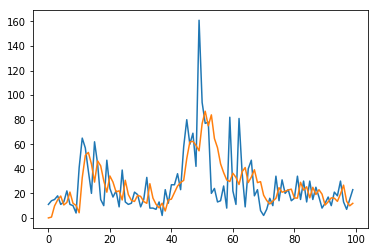

In [44]:
print(mse(preds[:, 1:],arr[:, 1:]))
plt.plot(arr[1][:100])
plt.plot(preds[1][:100])
plt.show()

mean:  1912.9527272727273 | pred_mean:  1438.4872727272727
var:  449410.7395834711 | pred_var:  107442.17347438016
correlation: [[1.         0.69805598]
 [0.69805598 1.        ]]
45657
35075


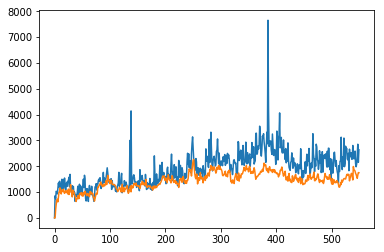

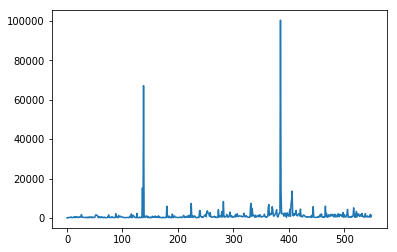

In [48]:
print("mean: ",np.mean(req_sum),"| pred_mean: ", np.mean(pred_req_sum))
print("var: ",np.var(req_sum),"| pred_var: ", np.var(pred_req_sum))
print("correlation:", np.corrcoef(req_sum,pred_req_sum))
print(np.count_nonzero(arr))
print(np.count_nonzero(preds))

plt.plot(range(len(req_sum)),req_sum)
plt.plot(range(len(pred_req_sum)),pred_req_sum)
plt.show()
plt.plot(range(len(error)),error)

Simple AE , scaled inputs , 0.8

In [34]:
exp_avg = None
windows = [1]

for r, window in enumerate(windows):
    req_sum = np.zeros(arr.shape[1])
    pred_req_sum = np.zeros(arr.shape[1])
    preds = np.zeros((arr.shape[0], arr.shape[1]))
    encoding_dim = int(arr.shape[0]*0.8)
    input_shape = Input(shape=(content_type,))
    encoded = Dense(encoding_dim, activation='sigmoid')(input_shape)
    decoded = Dense(content_type, activation='relu')(encoded)
    encoder = Model(input_shape, encoded)
    autoencoder = Model(input_shape, decoded)
    
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    autoencoder.compile(optimizer='adam', loss='mse')

    for w in range(window):
        preds[:, w] = 0
    for i in range(window, arr.shape[1]): # i -> timestep
        X = scale(arr[:,i].reshape(1,content_type).astype(float))
#         print(X.shape)
        p = autoencoder.predict(X)
#         print(p)
        preds[:, i] = p.reshape(content_type)
        autoencoder.fit(X, X, epochs=200, verbose=0)
        req_sum[i] = np.sum(X)
        pred_req_sum[i] = np.sum(p,dtype=int)


256795.3546151007


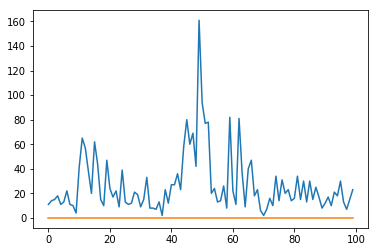

In [35]:
print(mse(preds[:, 1:],arr[:, 1:]))
plt.plot(arr[1][:100])
plt.plot(preds[1][:100])
plt.show()

### AutoEncoder 

- 5 past day requests
- exp moving average

(,6) => (,4) 

In [141]:
fig_size = plt.rcParams["figure.figsize"]
# print("Current size:", fig_size)
fig_size[0] = 18
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [162]:
exp_avg = None
windows = [5]

input_dim = 6
encoding_dim = 4

compression_factor = float(input_dim) / encoding_dim
print("Compression factor: %s" % compression_factor)

autoencoder = Sequential()
autoencoder.add(
    Dense(encoding_dim, input_shape=(input_dim,), activation='relu')
)
autoencoder.add(
    Dense(input_dim, activation='relu')
)

autoencoder.summary()

input_encoder = Input(shape=(input_dim,))
encoder_layer = autoencoder.layers[0]
encoder = Model(input_encoder, encoder_layer(input_encoder))

autoencoder.compile(optimizer='adam', loss='mse')

for r, window in enumerate(windows):
    model = Sequential()
    model.add(GRU(num_hidden_units))
    model.add(Dense(num_outputs))
    model.add(Activation('relu'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    req_sum = np.zeros(arr.shape[1])
    pred_req_sum = np.zeros(arr.shape[1])
    decoded_data = np.zeros((arr.shape[0], arr.shape[1]))
    preds = np.zeros((arr.shape[0], arr.shape[1]))
#     for w in range(window):
#         preds[:, w] = 0
    for i in range(window+1, arr.shape[1]): # i -> timestep
        print(i)
        if exp_avg is None:
            exp_avg = arr[:, i-1]
        else:
            exp_avg = alpha*arr[:, i-1] + (1-alpha)*exp_avg
#         print(i-window-1)
        y = np.copy(arr[:, i]).reshape(-1, 1)
        X = np.concatenate((np.copy(arr[:, i-1-window : i-1].reshape(content_type,window)),exp_avg.reshape(content_type,1)), axis=1)
#         print(X.shape)
        if i > int(arr.shape[1]*0):
            p = autoencoder.predict(X)
#             print(p[:,4].shape)
            decoded_data[:, i] = p[:,4].reshape(content_type)
            print(autoencoder.evaluate(X,X))
            e = encoder.predict(X).reshape(-1, 1, 4)
            p = model.predict(e).reshape(-1, 1, 4)
            preds[:, i] = p.reshape(content_type)
            model.fit(e, y, epochs=10, verbose=0)
        autoencoder.fit(X,X, epochs=20, verbose=0)

Compression factor: 1.5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_134 (Dense)            (None, 4)                 28        
_________________________________________________________________
dense_135 (Dense)            (None, 6)                 30        
Total params: 58
Trainable params: 58
Non-trainable params: 0
_________________________________________________________________
6
100/100 [==============================] - 1s 15ms/step
375.4795001220703
7
100/100 [==============================] - 0s 48us/step
140.11296966552734
8
100/100 [==============================] - 0s 76us/step
130.5690087890625
9
100/100 [==============================] - 0s 89us/step
169.89462951660155
10
100/100 [==============================] - 0s 53us/step
160.1603677368164
11
100/100 [==============================] - 0s 77us/step
147.11262634277344
12
100/100 [==============================] - 0s 79us/ste

100/100 [==============================] - 0s 67us/step
44.942689094543454
105
100/100 [==============================] - 0s 116us/step
61.778073692321776
106
100/100 [==============================] - 0s 84us/step
38.680105972290036
107
100/100 [==============================] - 0s 64us/step
34.765149955749514
108
100/100 [==============================] - 0s 88us/step
22.629940762519837
109
100/100 [==============================] - 0s 56us/step
22.547193112373353
110
100/100 [==============================] - 0s 73us/step
33.85653290748596
111
100/100 [==============================] - 0s 67us/step
27.926588592529296
112
100/100 [==============================] - 0s 86us/step
24.926537570953368
113
100/100 [==============================] - 0s 88us/step
11.52847282409668
114
100/100 [==============================] - 0s 74us/step
23.788815307617188
115
100/100 [==============================] - 0s 72us/step
44.56074339866638
116
100/100 [==============================] - 0s 61us/ste

100/100 [==============================] - 0s 77us/step
32.78433596611023
209
100/100 [==============================] - 0s 69us/step
32.76210509300232
210
100/100 [==============================] - 0s 69us/step
39.89702550888062
211
100/100 [==============================] - 0s 62us/step
38.03002203941345
212
100/100 [==============================] - 0s 95us/step
45.74875057697296
213
100/100 [==============================] - 0s 90us/step
82.02936674118043
214
100/100 [==============================] - 0s 68us/step
123.2282951927185
215
100/100 [==============================] - 0s 82us/step
46.1259751701355
216
100/100 [==============================] - 0s 69us/step
97.09004254341126
217
100/100 [==============================] - 0s 73us/step
75.38291763305664
218
100/100 [==============================] - 0s 79us/step
74.12796822547912
219
100/100 [==============================] - 0s 89us/step
109.13818970680236
220
100/100 [==============================] - 0s 52us/step
66.06058

100/100 [==============================] - 0s 77us/step
130.6082873916626
313
100/100 [==============================] - 0s 69us/step
99.93823043823242
314
100/100 [==============================] - 0s 49us/step
85.2753897857666
315
100/100 [==============================] - 0s 76us/step
57.20974899291992
316
100/100 [==============================] - 0s 54us/step
132.65846472740174
317
100/100 [==============================] - 0s 74us/step
101.7561212348938
318
100/100 [==============================] - 0s 66us/step
40.378134117126464
319
100/100 [==============================] - 0s 66us/step
64.32182580947875
320
100/100 [==============================] - 0s 80us/step
118.54428371429444
321
100/100 [==============================] - 0s 64us/step
82.41978216171265
322
100/100 [==============================] - 0s 80us/step
99.63968404769898
323
100/100 [==============================] - 0s 63us/step
59.516110267639164
324
100/100 [==============================] - 0s 57us/step
78.30

100/100 [==============================] - 0s 66us/step
100.70155361175537
417
100/100 [==============================] - 0s 95us/step
89.92802261352539
418
100/100 [==============================] - 0s 96us/step
215.48503353118898
419
100/100 [==============================] - 0s 51us/step
216.98083450317384
420
100/100 [==============================] - 0s 74us/step
144.4529867553711
421
100/100 [==============================] - 0s 88us/step
83.48441047668457
422
100/100 [==============================] - 0s 74us/step
274.30445892333984
423
100/100 [==============================] - 0s 80us/step
312.6689292907715
424
100/100 [==============================] - 0s 75us/step
271.4994091796875
425
100/100 [==============================] - 0s 71us/step
141.47236129760742
426
100/100 [==============================] - 0s 91us/step
139.5514762878418
427
100/100 [==============================] - 0s 58us/step
120.53275665283203
428
100/100 [==============================] - 0s 73us/step
81

126.09345520019531
521
100/100 [==============================] - 0s 69us/step
73.49360832214356
522
100/100 [==============================] - 0s 80us/step
193.02214447021484
523
100/100 [==============================] - 0s 67us/step
152.1108790588379
524
100/100 [==============================] - 0s 88us/step
93.87492736816407
525
100/100 [==============================] - 0s 76us/step
215.13052993774414
526
100/100 [==============================] - 0s 90us/step
207.47777954101562
527
100/100 [==============================] - 0s 103us/step
83.05177597045899
528
100/100 [==============================] - 0s 47us/step
144.60399963378907
529
100/100 [==============================] - 0s 77us/step
117.18571563720702
530
100/100 [==============================] - 0s 71us/step
84.46526067733765
531
100/100 [==============================] - 0s 90us/step
96.16544555664062
532
100/100 [==============================] - 0s 83us/step
104.49824913024902
533
100/100 [=========================

1272.4759416980053


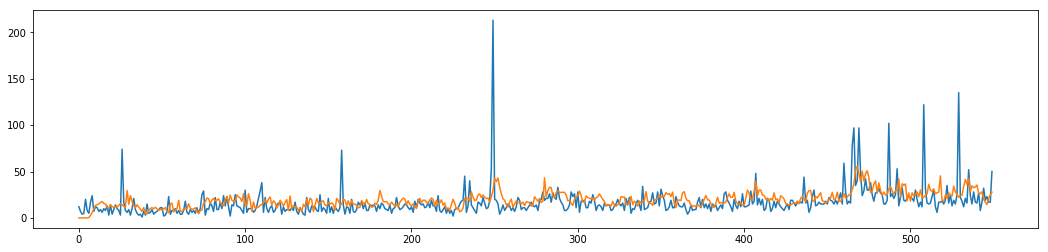

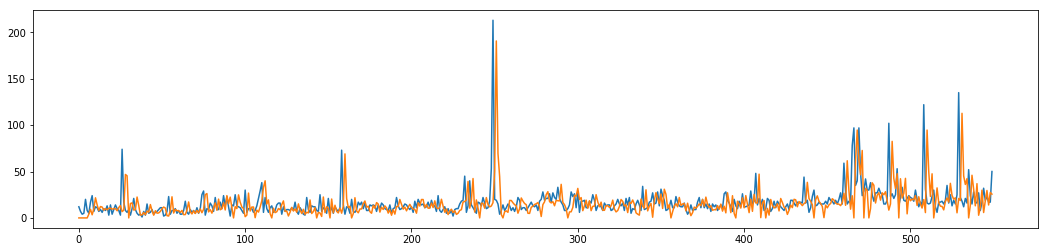

In [163]:
print(mse(preds[:, 1:],arr[:, 1:]))
plt.plot(arr[5][:])
plt.plot(preds[5][:])
plt.show()
plt.plot(arr[5][:])
plt.plot(decoded_data[5][:])


In [135]:
p[:,4]

array([ 17.884674  ,  24.569016  ,   3.838765  ,  10.101315  ,
        34.894905  ,  16.704617  ,   7.5470753 ,  33.304497  ,
        31.703613  ,  25.887482  ,  14.086426  ,  11.731964  ,
         4.2502804 ,  18.229515  ,  36.582436  , 108.63336   ,
        13.4147415 ,  11.128319  ,   8.466549  ,   7.2731876 ,
        21.916588  ,  21.524048  ,  11.973091  ,  28.63443   ,
        22.084747  ,  14.596794  ,  41.94796   ,  12.222252  ,
        37.94214   ,  18.584068  ,  15.277     ,   9.850733  ,
        10.727886  ,  32.94005   ,  11.819805  ,  20.175697  ,
        19.78035   ,   6.843113  ,  17.706177  ,   8.310558  ,
        16.711853  ,  66.80655   ,   2.6077154 ,   8.305725  ,
       124.04018   ,  16.42781   ,   1.46191   ,  47.819626  ,
         7.7258263 ,  14.073975  ,  23.212181  ,  25.220879  ,
         0.726074  ,   0.6456561 ,   0.        ,   0.68064976,
         0.99633354,  49.979095  ,   7.6467514 ,  58.879265  ,
        53.82325   ,  53.79297   ,   3.6646574 ,  15.61

In [136]:
X[:,4]

array([18, 26, 4, 10, 36, 17, 8, 32, 31, 26, 12, 11, 5, 21, 38, 111, 12,
       12, 9, 8, 21, 21, 13, 32, 28, 15, 42, 12, 39, 19, 17, 10, 11, 30,
       11, 21, 20, 8, 18, 9, 14, 64, 3, 8, 124, 17, 2, 48, 8, 12, 24, 26,
       1, 1, 0, 1, 1, 48, 8, 57, 58, 55, 4, 16, 63, 38, 15, 12, 14, 9, 13,
       8, 9, 89, 47, 52, 37, 9, 9, 16, 0, 7, 6, 7, 25, 14, 25, 22, 13, 12,
       17, 2, 6, 8, 19, 5, 46, 5, 4, 27], dtype=object)

In [140]:
decoded_data.shape

(100, 4)